# Mutational antigenic profiling of 1-18
### Adam S. Dingens, Jesse Bloom
### In collaboration with Florian Klein's group, particularly Philipp Schommers and Henning Gruell.

We are performing mutational antigenic profiling of 1-18, using the BG505.T332N mutant Env libraries, first described and characterized in [Haddox, Dingens et al 2018](https://elifesciences.org/articles/34420). The triplicate mutant libraries examined here correspond to the three BG505 replicates in this paper. Replicates annotated with an additional letter (i.e. "rep 1b") were done on an indepdent day and have their own mock selected control. 

The _fraction surviving_ statistic used in this analysis is explained in detail [here](https://jbloomlab.github.io/dms_tools2/fracsurvive.html). Our first mutational antigenic profiling analysis of escape from PGT151 using the BF520 env libraries was published [here](http://dx.doi.org/10.1016/j.chom.2017.05.003) in June 2017, and this original analysis is located [in this ipython notebook](https://github.com/adingens/BF520_MutationalAntigenicProfiling_PGT151).

We use [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to analyze these data. This notebook processes the Illumina deep sequencing data software package, and then analyzes the selection in the context of the antibody. Experiments and analysis performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019. 

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import glob
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import rpy2
import rpy2.robjects 
import dms_tools2.rplot
import string
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import numpy as np
import pylab as plt

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 14

# do we use existing results or generate everything new?
use_existing = "yes"

Using dms_tools2 version 2.5.1


In [2]:
homologs = ['BG505']

# files with codon sequences
wtseqfiles = dict([(env, './data/{0}_env.fasta'.format(env)) for env in homologs])

#the mutagenized codon sites in 1, 2, ... numbering
#for both this is 31-702 in HXB2 numbering
mutagenizedsites = {
        'BG505':list(range(30, 699 + 1))
        }

In [3]:
protalignmentfile = './data/Env_protalign_manualeditAD.fasta'
alignedprots = dict([(seq.name, str(seq.seq)) for seq in 
        Bio.SeqIO.parse(protalignmentfile, 'fasta')])

In [4]:
renumbdir = os.path.join(resultsdir, 'HXB2_numbering')
if not os.path.isdir(renumbdir):
    os.mkdir(renumbdir)

# keyed by homolog, value is renumbering file
renumbfile = {}
    
for env in homologs:
    
    # first build numbering with HXB2 numbers potentially repeated
    hxb2_r = 1
    hxb2_nums = [] # holds HXB2 numbers
    wildtype_aas = []
    nglycan = []
    alignedenv = alignedprots[env]
    envlen = len(alignedenv)
    for (r, (hxb2_aa, aa)) in enumerate(zip(alignedprots['HXB2'], alignedenv)):
        if aa != '-':
            hxb2_nums.append(str(hxb2_r - int(hxb2_aa == '-')))
            wildtype_aas.append(aa)
            if aa == 'N' and r + 2 < envlen and alignedenv[r + 2] in {'S', 'T'}:
                nglycan.append(True)
            elif aa in {'S', 'T'} and alignedenv[r - 2] == 'N':
                nglycan.append(True)
            elif aa != 'P' and r + 1 < envlen and alignedenv[r + 1] in {'S', 'T'} and alignedenv[r - 1] == 'N':
            #elif aa not in {'P'} and alignedenv[r + 1] in {'S', 'T'} and alignedenv[r - 1] == 'N':
                nglycan.append(True)
            else:
                nglycan.append(False)
        if hxb2_aa != '-':
            hxb2_r += 1
            
    # now take all runs of HXB2 numbers and make them 10, 10a, 10b, etc...
    for num in set(hxb2_nums):
        n_num = hxb2_nums.count(num)
        firstnum = hxb2_nums.index(num)
        for i in range(n_num - 1):
            hxb2_nums[firstnum + i + 1] = num + string.ascii_lowercase[i]
                
    # now write renumbering file
    renumbfile[env] = os.path.join(renumbdir, '{0}_to_HXB2.csv'.format(env))
    print("Writing HXB2 renumbering file for {0} to {1}".format(
            env, renumbfile[env]))
    with open(renumbfile[env], 'w') as f:
        f.write('original,new,wildtype,N-glycan\n')
        for (r, new) in enumerate(hxb2_nums):
            if r+1 not in mutagenizedsites[env]:
                continue
            else:
                f.write('{0},{1},{2},{3}\n'.format(r + 1, new, wildtype_aas[r],
                        nglycan[r]))

Writing HXB2 renumbering file for BG505 to ./results/HXB2_numbering/BG505_to_HXB2.csv


## Download the sequencing data from the Sequence Read Archive
Here we download sequencing data for each sample from the [Sequence Read Archive](http://www.ncbi.nlm.nih.gov/sra). Sample names specificy if they are mutant (mut) or wildtype (wt), as well as virus (virus) or DNA (DNA). The _rep#_ is which replicate.  If a sample is antibody selected, it also has the antibody and `ug/mL` concentration. There is metadata available from the SRA, and the dictionary below also specifies the accession number of each sample.

The 1-18 reads were submitted as SRA # [PRJNA561627](https://www.ncbi.nlm.nih.gov/sra/PRJNA561627) with SRA accession numbers `SRX6752366-SRX6752371`  on Aug 22, 2019. The BioProject ID is `PRJNA561627`. 

We will also re-analyze data on VRC01 and 3BNC117 from [Dingens et al Immunity 2019](https://www.cell.com/immunity/fulltext/S1074-7613(18)30565-X). These reads were submitted as SRA submission [SRP157948](https://www.ncbi.nlm.nih.gov/sra/SRP157948) on Aug 14 and Aug 27, 2018. The BioProject ID is `PRJNA486029`. 

We download these files using the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html) function from the dms_tools2 Python API. Note that the call to this function below uses two external programs that are not part of dms_tools2, and which you therefore must install externally on the computer that you are using:
1. The fastq-dump program from the SRA Toolkit. If you do not already have this toolkit installed, you will need to install a relatively recent version.
2. The Aspera Connect program for rapid downloads. You need both the executable ascp and an Aspera Key file. Installing Aspera Connect and a key can be somewhat complex, so if you do not want to do this then just set aspera=None in the command below and fastq-dump will do the downloads (albeit more slowly).



In [5]:
samples = pd.DataFrame.from_records(
#new data published here for 1-18
        [('BG505_mut_virus_rep3d_1-18-4ug','SRR10014244'),
         ('BG505_mut_virus_rep3d_1-18-8ug','SRR10014243'),
         ('BG505_mut_virus_rep2d_1-18-4ug','SRR10014242'),
         ('BG505_mut_virus_rep2d_1-18-8ug','SRR10014241'),
         ('BG505_mut_virus_rep2d','SRR10014240'),
         ('BG505_mut_virus_rep3d','SRR10014239'),
#Data on VRC01 and 3BNC117 from Dingens et al Immunity 2019 
#Here, I do not download the data on 10-1074 and pooled 10-1074/3BNC117. While I look at this data briefly for one analysis, I simply download the analyzed files from github rather than redoing all analyses. However these can be downloaded and anaylzed in parallel by uncommentin the relevant lines below. 
         ('BG505_mut-virus-rep1b','SRR7693968'),
         ('BG505_mut-virus-rep2b-3BNC117-4ug','SRR7693969'),
#         ('BG505_wt-virus-rep2b','SRR7693970'),
         ('BG505_mut-virus-rep1-VRC01-11ug','SRR7693971'),
#         ('BG505_wt-virus-rep3','SRR7693972'),
#         ('BG505_mut-virus-rep2b-101074-3ug','SRR7693974'),
         ('BG505_mut-virus-rep3','SRR7693976'),
         ('BG505_mut-virus-rep3-3BNC117-1-1ug','SRR7693977'),
#         ('BG505_mut-virus-rep2b-3BN-1074-pool-4ug','SRR7693978'),
#         ('BG505_mut-virus-rep1b-3BN-1074-pool-3ug','SRR7693979'),
#         ('BG505_wt-virus-rep1b','SRR7693980'),
#         ('BG505_mut-virus-rep1b-3BN-1074-pool-4ug','SRR7693981'),
#         ('BG505_mut-virus-rep3b-3BN-1074-pool-4ug','SRR7693982'),
#         ('BG505_wt-virus-rep1','SRR7693983'),
#         ('BG505_wt-virus-rep3b','SRR7693984'),
#         ('BG505_mut-virus-rep2b-101074-4ug','SRR7693985'),
         ('BG505_mut-DNA-rep1','SRR7693986'),
         ('BG505_mut-DNA-rep3','SRR7694021'),
         ('BG505_mut-virus-rep2b','SRR7694018'),
         ('BG505_wt-DNA-rep3','SRR7694017'),
         ('BG505_mut-virus-rep2-VRC01-8ug','SRR7694015'),
#         ('BG505_mut-virus-rep2b-3BN-1074-pool-3ug','SRR7694014'),
#         ('BG505_wt-virus-rep2','SRR7694013'),
#         ('BG505_mut-virus-rep3b-101074-4ug','SRR7694011'),
#         ('BG505_mut-virus-rep3b-3BN-1074-pool-3ug','SRR7694009'),
         ('BG505_mut-virus-rep1b-3BNC117-4ug','SRR7694006'),
         ('BG505_mut-virus-rep3b-3BNC117-4ug','SRR7694005'),
#         ('BG505_mut-virus-rep1b-101074-4ug','SRR7694004'),
         ('BG505_mut-virus-rep3b','SRR7694003'),
         ('BG505_mut-DNA-rep2','SRR7694002'),
         ('BG505_wt-DNA-rep2','SRR7693998'),
         ('BG505_mut-virus-rep2','SRR7693997'),
         ('BG505_mut-virus-rep3-VRC01-tr2-11ug','SRR7693996'),
         ('BG505_mut-virus-rep3-VRC01-11ug','SRR7693992'),
         ('BG505_mut-virus-rep2-VRC01-11ug','SRR7693991'),
         ('BG505_mut-virus-rep2b-3BNC117-3ug','SRR7693990'),
         ('BG505_wt-DNA-rep1','SRR7693989'),
         ('BG505_mut-virus-rep1','SRR7693987')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

Here are the names of the downloaded files now found in ./results/FASTQ_files/


name,run,R1,R2
BG505_mut_virus_rep3d_1-18-4ug,SRR10014244,BG505_mut_virus_rep3d_1-18-4ug_R1.fastq.gz,BG505_mut_virus_rep3d_1-18-4ug_R2.fastq.gz
BG505_mut_virus_rep3d_1-18-8ug,SRR10014243,BG505_mut_virus_rep3d_1-18-8ug_R1.fastq.gz,BG505_mut_virus_rep3d_1-18-8ug_R2.fastq.gz
BG505_mut_virus_rep2d_1-18-4ug,SRR10014242,BG505_mut_virus_rep2d_1-18-4ug_R1.fastq.gz,BG505_mut_virus_rep2d_1-18-4ug_R2.fastq.gz
BG505_mut_virus_rep2d_1-18-8ug,SRR10014241,BG505_mut_virus_rep2d_1-18-8ug_R1.fastq.gz,BG505_mut_virus_rep2d_1-18-8ug_R2.fastq.gz
BG505_mut_virus_rep2d,SRR10014240,BG505_mut_virus_rep2d_R1.fastq.gz,BG505_mut_virus_rep2d_R2.fastq.gz
BG505_mut_virus_rep3d,SRR10014239,BG505_mut_virus_rep3d_R1.fastq.gz,BG505_mut_virus_rep3d_R2.fastq.gz
BG505_mut-virus-rep1b,SRR7693968,BG505_mut-virus-rep1b_R1.fastq.gz,BG505_mut-virus-rep1b_R2.fastq.gz
BG505_mut-virus-rep2b-3BNC117-4ug,SRR7693969,BG505_mut-virus-rep2b-3BNC117-4ug_R1.fastq.gz,BG505_mut-virus-rep2b-3BNC117-4ug_R2.fastq.gz
BG505_mut-virus-rep1-VRC01-11ug,SRR7693971,BG505_mut-virus-rep1-VRC01-11ug_R1.fastq.gz,BG505_mut-virus-rep1-VRC01-11ug_R2.fastq.gz
BG505_mut-virus-rep3,SRR7693976,BG505_mut-virus-rep3_R1.fastq.gz,BG505_mut-virus-rep3_R2.fastq.gz


## Define samples from FASTQ_files

In [6]:
R1fastqfilelist_df = pd.read_csv("./data/samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

name,R1
mut-virus-rep3d,BG505_mut_virus_rep3d_R1.fastq.gz
mut-virus-rep2d,BG505_mut_virus_rep2d_R1.fastq.gz
mut-virus-rep2d-118-4ug,BG505_mut_virus_rep2d_1-18-4ug_R1.fastq.gz
mut-virus-rep2d-118-8ug,BG505_mut_virus_rep2d_1-18-8ug_R1.fastq.gz
mut-virus-rep3d-118-4ug,BG505_mut_virus_rep3d_1-18-4ug_R1.fastq.gz
mut-virus-rep3d-118-8ug,BG505_mut_virus_rep3d_1-18-8ug_R1.fastq.gz
mut-virus-rep3,BG505_mut-virus-rep3_R1.fastq.gz
mut-virus-rep2b-3BNC117-4ug,BG505_mut-virus-rep2b-3BNC117-4ug_R1.fastq.gz
mut-virus-rep1-VRC01-11ug,BG505_mut-virus-rep1-VRC01-11ug_R1.fastq.gz
mut-virus-rep3-3BNC117-1-1ug,BG505_mut-virus-rep3-3BNC117-1-1ug_R1.fastq.gz


## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [7]:
refseq = './data/BG505.W6.C2.T332N_env.fasta'

fastqdir ='./results/FASTQ_files/'
# define subamplicon alignment specifications
alignspecs = ' '.join(['87,375,39,36', 
                       '376,666,36,39',
                       '663,954,33,41',
                       '955,1228,33,37',
                       '1228,1527,34,35',
                       '1527,1815,32,39',
                       '1816,2098,36,41'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1fastqfilelist_df[['name', 'R1']].to_html(index=False)))
R1fastqfilelist_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 15 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
mut-virus-rep3d,BG505_mut_virus_rep3d_R1.fastq.gz
mut-virus-rep2d,BG505_mut_virus_rep2d_R1.fastq.gz
mut-virus-rep2d-118-4ug,BG505_mut_virus_rep2d_1-18-4ug_R1.fastq.gz
mut-virus-rep2d-118-8ug,BG505_mut_virus_rep2d_1-18-8ug_R1.fastq.gz
mut-virus-rep3d-118-4ug,BG505_mut_virus_rep3d_1-18-4ug_R1.fastq.gz
mut-virus-rep3d-118-8ug,BG505_mut_virus_rep3d_1-18-8ug_R1.fastq.gz
mut-virus-rep3,BG505_mut-virus-rep3_R1.fastq.gz
mut-virus-rep2b-3BNC117-4ug,BG505_mut-virus-rep2b-3BNC117-4ug_R1.fastq.gz
mut-virus-rep1-VRC01-11ug,BG505_mut-virus-rep1-VRC01-11ug_R1.fastq.gz
mut-virus-rep3-3BNC117-1-1ug,BG505_mut-virus-rep3-3BNC117-1-1ug_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [8]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

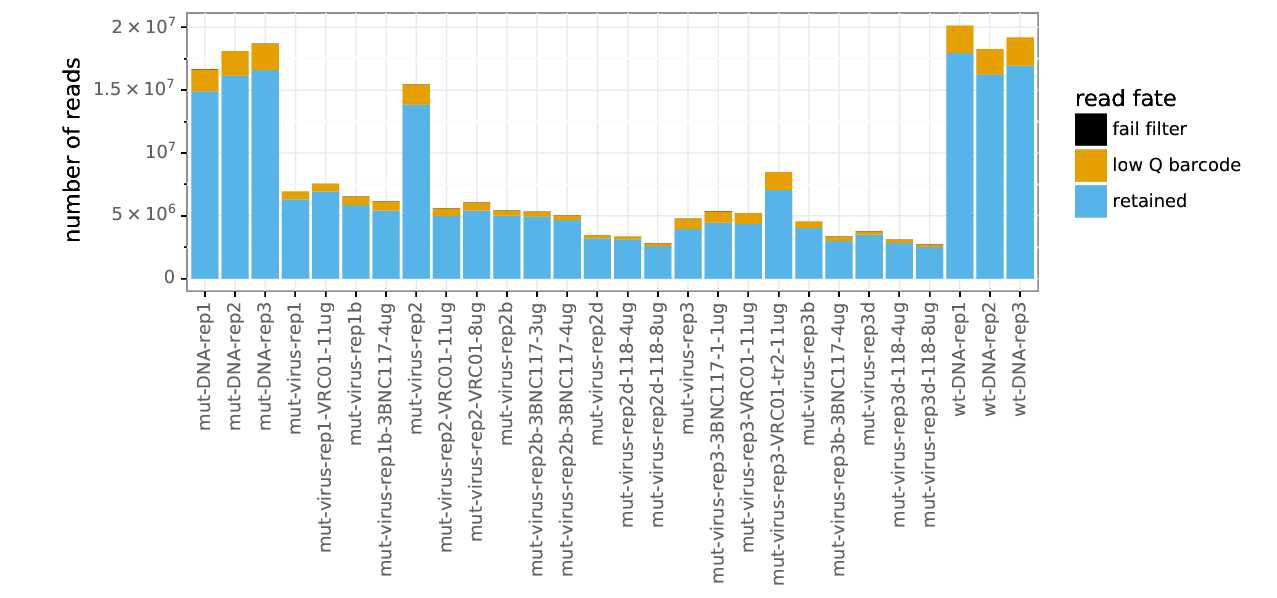

In [9]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

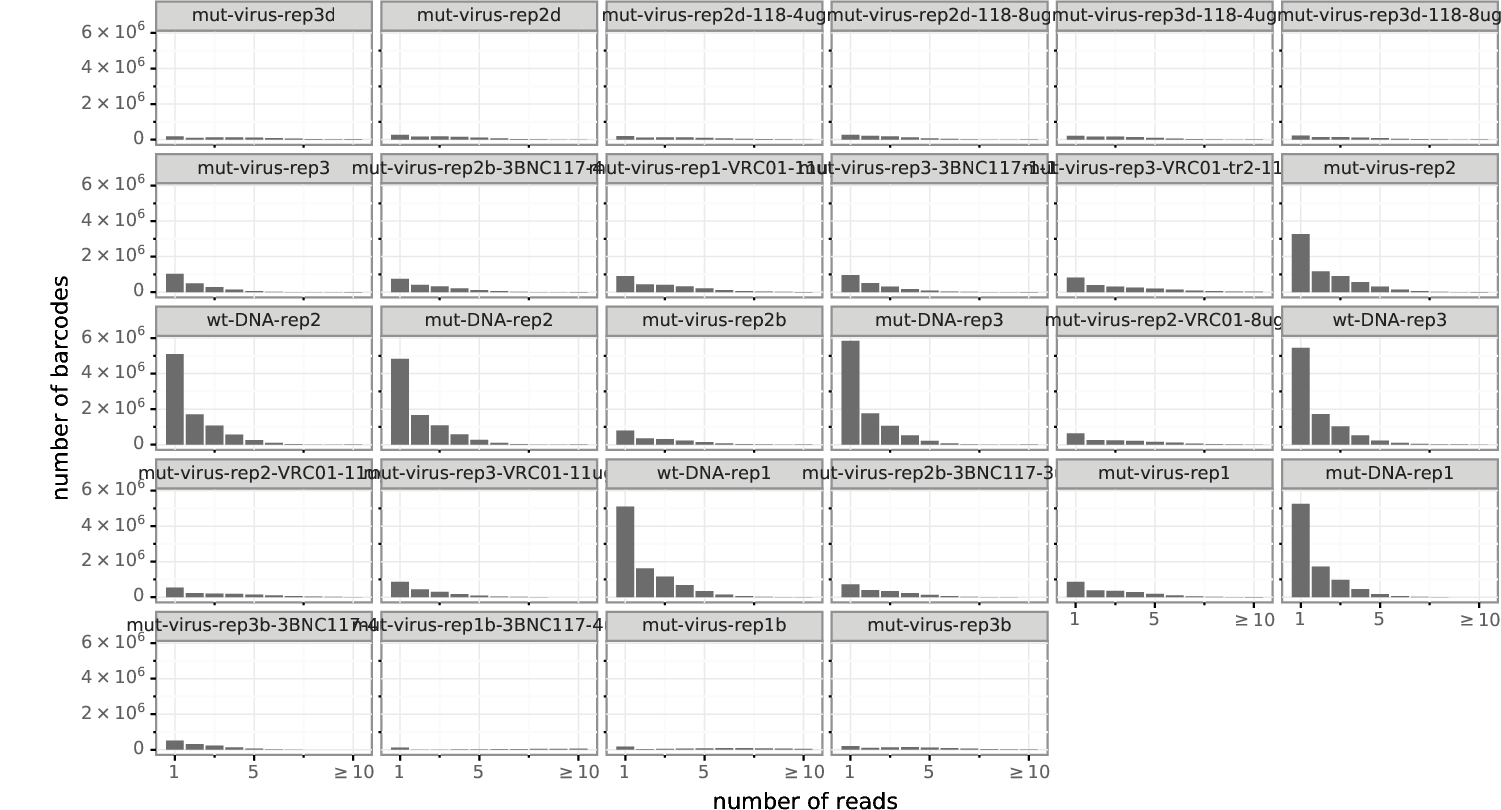

In [10]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

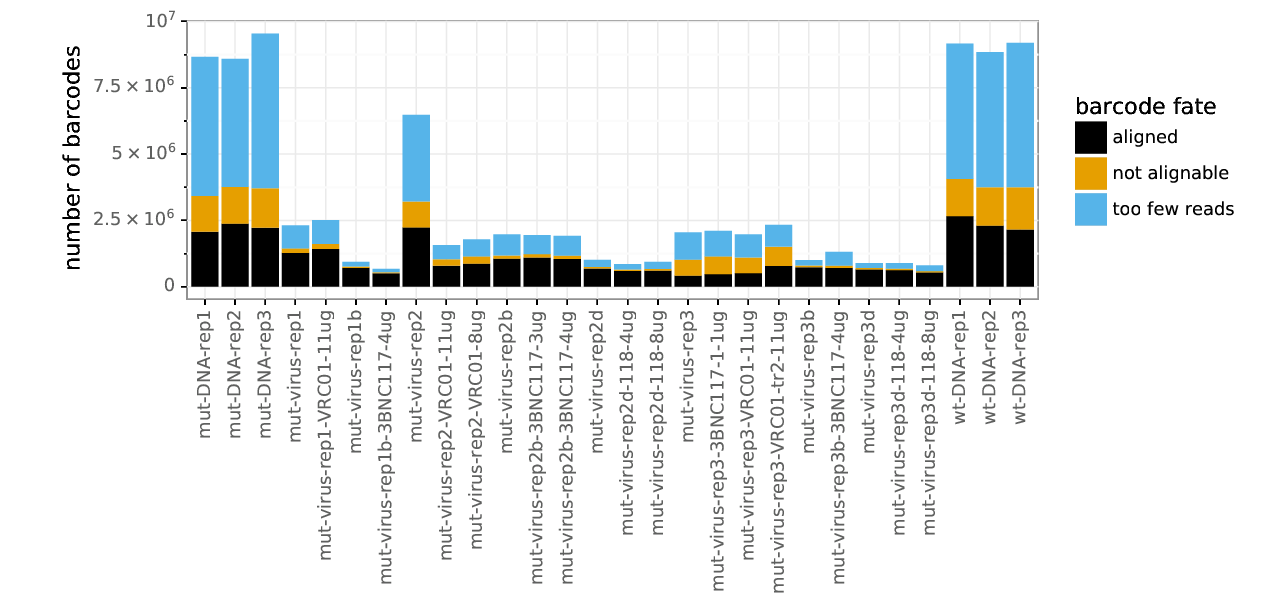

In [11]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

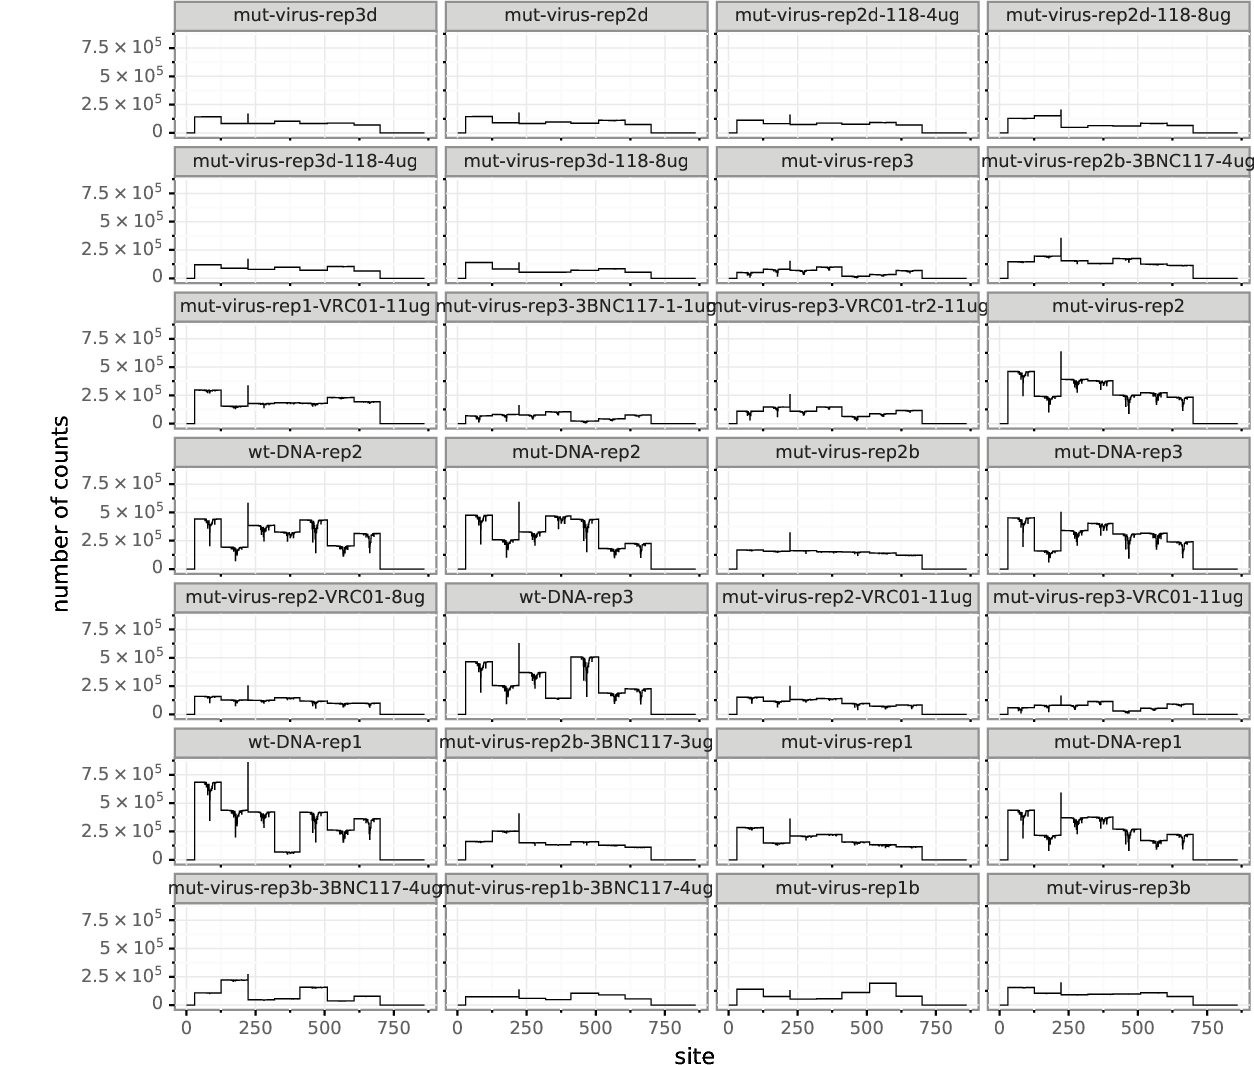

In [12]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

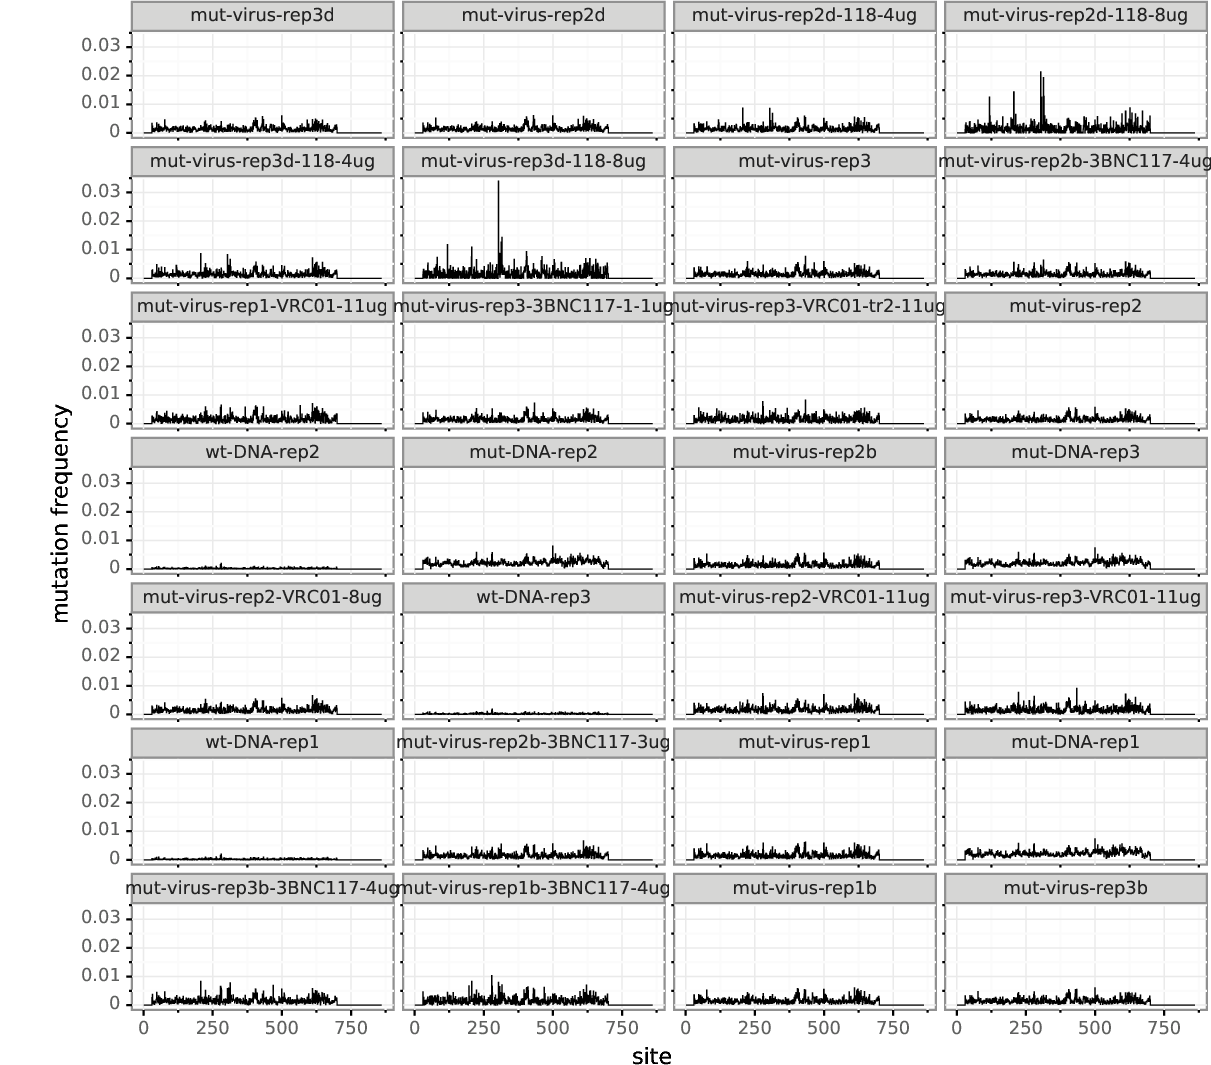

In [13]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 

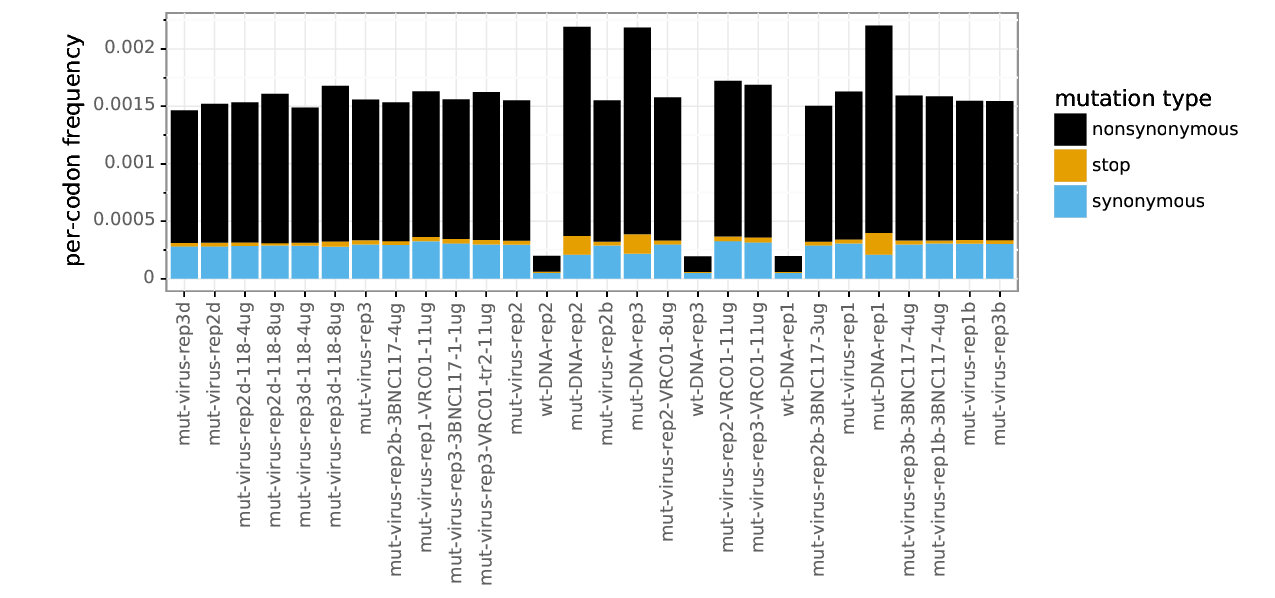

In [14]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

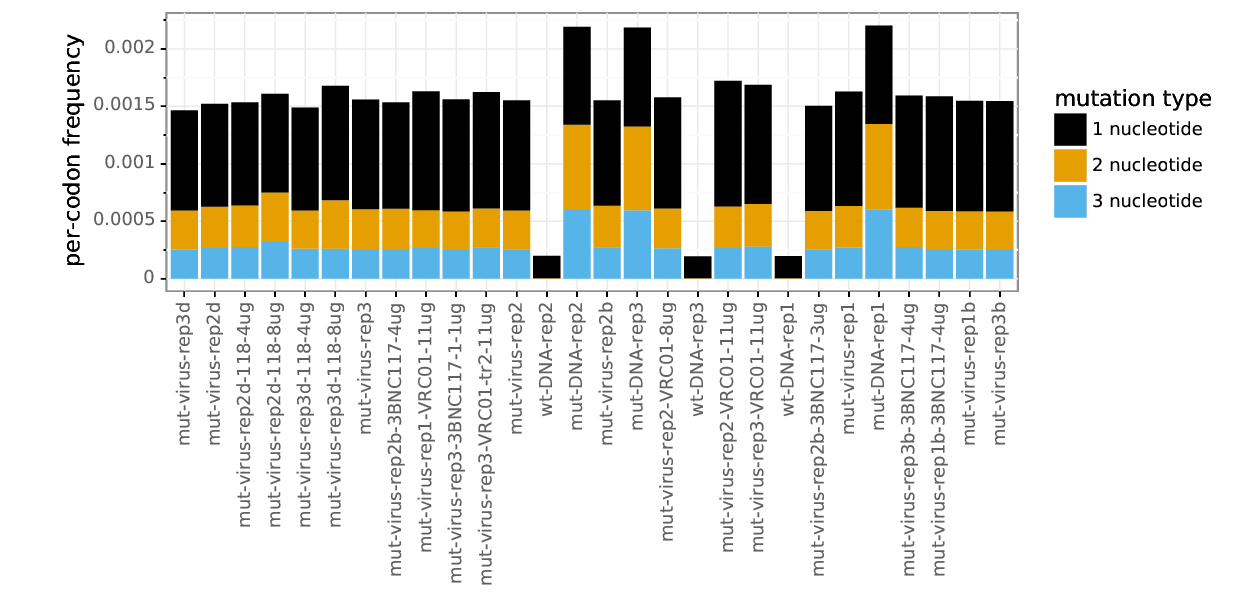

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

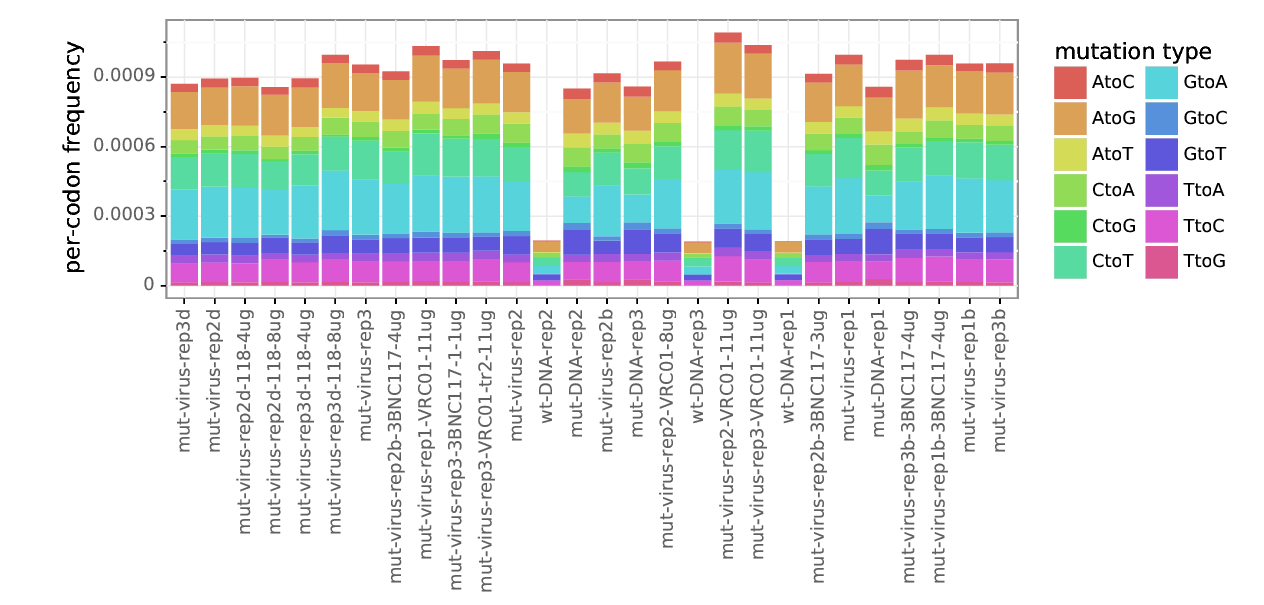

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

## Renumber codon counts to HXB2 numbering 
The standard numbering scheme for HIV Env is the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
The file [./data/BF520c2_to_HXB2.csv](./data/BF520c2_to_HXB2.csv) gives the mapping from sequential 1, 2, ... numbering of the BF520 protein sequence to the HXB2 numbering scheme. 
This file was generated by aligning the HXB2 sequence [taken from Genbank](http://www.ncbi.nlm.nih.gov/protein/1906385) with the BF520c2 sequence using the [LANL alignment interface](http://www.hiv.lanl.gov/cgi-bin/VIRALIGN/viralign.cgi) at the protein sequence level. 
Insertions relative to HXB2 are given letter suffixes as [described here](http://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).

Additionally, not all residues in BF520 Env were mutagenized. 
The N-terminal signal peptide and the C-terminal cytoplasmic tail were excluded because they seem likely to affect expression level. 
These sites are not listed in the renumbering file, and so are dropped when we do the re-numbering.

To do the re-numbering, we use the [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function from the [dms_tools Python API](https://jbloomlab.github.io/dms_tools2/api.html) to create a new directory that contains all of the re-numbered files with the same name as in the original codon counts directory produced above.

In [17]:
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

In [18]:
renumberfile = './results/HXB2_numbering/BG505_to_HXB2.csv'

# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Compute the fraction surviving 
Now we compute the [fraction surviving](https://jbloomlab.github.io/dms_tools2/fracsurvive.html).This caluclation takes into account the level of antibody selection, found in the input file below. We will use mutliple different controls to estimate the error rates to  correct fo, and put the output in its own subdirectory, named according to its control sample. 

This [csv file](/data/BG505_qPCR_master.csv) contains the fraction remaining infectivity for each antibody selected sample, as quatified using pol qPCR and computed based on a standard curve of infecting cells with dilutions of mutant virus (library and experiment specific), with dilutiuons ranging from 0.1 to .0001. 

We first create a batch file to use with [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html). 
Note we make the **group** argument the antibody, the **name** argument the replicate, and assign the **sel**, **mock**, and **err** arguments based on the names used for the batch file when generating the counts files above with `dms2_batch_bcsubamp`.
By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) to analyze these together and take their mean and median.

### Average fraction surviving across multiple antibody dilutions
For select antibodies, we have escape profiles at numerous dilutions. Oftentimes, the antibody concentrations are quite similar (e.g. 3 vs 4 ug/mL), and the single replicate escape profiles look very similar as well. I am averaging across these additional dilutions. 


In [19]:
fracsurvivedir = os.path.join(resultsdir, 'fracsurvive')
if not os.path.isdir(fracsurvivedir):
    os.mkdir(fracsurvivedir)
    
fracsurviveaboveavgdir = os.path.join(resultsdir, 'fracsurviveaboveavg')
if not os.path.isdir(fracsurviveaboveavgdir):
    os.mkdir(fracsurviveaboveavgdir) 

In [20]:
fracsurvivebatchavg = pd.read_csv("./data/118_VRC01_3BNC117_avgconcentrations_fracsurvive.csv", header =0)
fracsurvivebatchavg = fracsurvivebatchavg.sort_values(by='group')
display(HTML(fracsurvivebatchavg.to_html(index=False)))

group,name,sel,mock,err,mds_names,libfracsurvive
118,4ug-rep2d,mut-virus-rep2d-118-4ug,mut-virus-rep2d,wt-DNA-rep2,118-4ug-rep2d,0.005177
118,8ug-rep2d,mut-virus-rep2d-118-8ug,mut-virus-rep2d,wt-DNA-rep2,118-8ug-rep2d,0.000168
118,4ug-rep3d,mut-virus-rep3d-118-4ug,mut-virus-rep3d,wt-DNA-rep3,118-4ug-rep3d,0.005182
118,8ug-rep3d,mut-virus-rep3d-118-8ug,mut-virus-rep3d,wt-DNA-rep3,118-8ug-rep3d,0.000673
3BNC117,3ug-rep2b,mut-virus-rep2b-3BNC117-3ug,mut-virus-rep2b,wt-DNA-rep2,3BNC117-3ug-rep2b,0.009847
3BNC117,4ug-rep2b,mut-virus-rep2b-3BNC117-4ug,mut-virus-rep2b,wt-DNA-rep2,3BNC117-4ug-rep2b,0.022027
3BNC117,4ug-rep3b,mut-virus-rep3b-3BNC117-4ug,mut-virus-rep3b,wt-DNA-rep3,3BNC117-4ug-rep3b,0.006475
3BNC117,4ug-rep1b,mut-virus-rep1b-3BNC117-4ug,mut-virus-rep1b,wt-DNA-rep1,3BNC117-4ug-rep1b,0.008765
VRC01,11ug-rep1,mut-virus-rep1-VRC01-11ug,mut-virus-rep1,wt-DNA-rep1,VRC01-11ug-rep1,0.002029
VRC01,11ug-rep3,mut-virus-rep3-VRC01-11ug,mut-virus-rep3,wt-DNA-rep3,VRC01-11ug-rep3,0.007226


In [21]:
fracsurvivebatchavgcopy = fracsurvivebatchavg.copy()


names = fracsurvivebatchavg["group"].astype(str) + "-" + fracsurvivebatchavg["name"].astype(str)
names = names.tolist()

We now `run dms2_batch_survive` twice with the following difference:
    1. First we run it simply computing the fraction surviving for each mutation.
    2. Then we run it with the --aboveavg yes option to compute the fraction surviving for each mutation above the overall library average.

Note how the results for these two different runs are output to two different subdirectories.


In [22]:
fracsurvivebatch = fracsurvivebatchavg.copy()
fracsurvivebatchfile = os.path.join(fracsurvivedir, 'batch.csv')
print("Here is the batch input that we write to the CSV file {0}:".format(fracsurvivebatchfile))
display(HTML(fracsurvivebatch.to_html(index=False)))
fracsurvivebatch.to_csv(fracsurvivebatchfile, index=False, encoding='utf-8')


for (arg_aboveavg, outdir) in [('', fracsurvivedir), ('--aboveavg yes', fracsurviveaboveavgdir)]:
    print("\nRunning dms2_batch_fracsurvive {0}and writing output to {1}".format(
            {'':'', '--aboveavg yes':'with `--aboveavg yes` '}[arg_aboveavg], outdir))
    log = !dms2_batch_fracsurvive \
            --summaryprefix summary \
            --batchfile {fracsurvivebatchfile} \
            --outdir {outdir} \
            --indir {renumberedcountsdir} \
            --use_existing {use_existing} \
            {arg_aboveavg} 
    print("Completed run.")

Here is the batch input that we write to the CSV file ./results/fracsurvive/batch.csv:


group,name,sel,mock,err,mds_names,libfracsurvive
118,4ug-rep2d,mut-virus-rep2d-118-4ug,mut-virus-rep2d,wt-DNA-rep2,118-4ug-rep2d,0.005177
118,8ug-rep2d,mut-virus-rep2d-118-8ug,mut-virus-rep2d,wt-DNA-rep2,118-8ug-rep2d,0.000168
118,4ug-rep3d,mut-virus-rep3d-118-4ug,mut-virus-rep3d,wt-DNA-rep3,118-4ug-rep3d,0.005182
118,8ug-rep3d,mut-virus-rep3d-118-8ug,mut-virus-rep3d,wt-DNA-rep3,118-8ug-rep3d,0.000673
3BNC117,3ug-rep2b,mut-virus-rep2b-3BNC117-3ug,mut-virus-rep2b,wt-DNA-rep2,3BNC117-3ug-rep2b,0.009847
3BNC117,4ug-rep2b,mut-virus-rep2b-3BNC117-4ug,mut-virus-rep2b,wt-DNA-rep2,3BNC117-4ug-rep2b,0.022027
3BNC117,4ug-rep3b,mut-virus-rep3b-3BNC117-4ug,mut-virus-rep3b,wt-DNA-rep3,3BNC117-4ug-rep3b,0.006475
3BNC117,4ug-rep1b,mut-virus-rep1b-3BNC117-4ug,mut-virus-rep1b,wt-DNA-rep1,3BNC117-4ug-rep1b,0.008765
VRC01,11ug-rep1,mut-virus-rep1-VRC01-11ug,mut-virus-rep1,wt-DNA-rep1,VRC01-11ug-rep1,0.002029
VRC01,11ug-rep3,mut-virus-rep3-VRC01-11ug,mut-virus-rep3,wt-DNA-rep3,VRC01-11ug-rep3,0.007226



Running dms2_batch_fracsurvive and writing output to ./results/fracsurvive
Completed run.

Running dms2_batch_fracsurvive with `--aboveavg yes` and writing output to ./results/fracsurviveaboveavg
Completed run.


Running [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) creates plots showing how the fraction surviving estimates correlate among replicates. 
These plots have names like `summary_*-avgfracsurvivecorr.pdf` and `summary_*-maxfracsurvivecorr.pdf`. 
Note that the plots show the correlations between all pairs, and also on the diagonal show the density of the different selection values for each replicates (most of them are close to zero).

In [23]:
fracsurviveprefix = os.path.join(fracsurvivedir, 'summary_')
groups = fracsurvivebatchavg['group'].unique()



avgfracsurvive correlations:


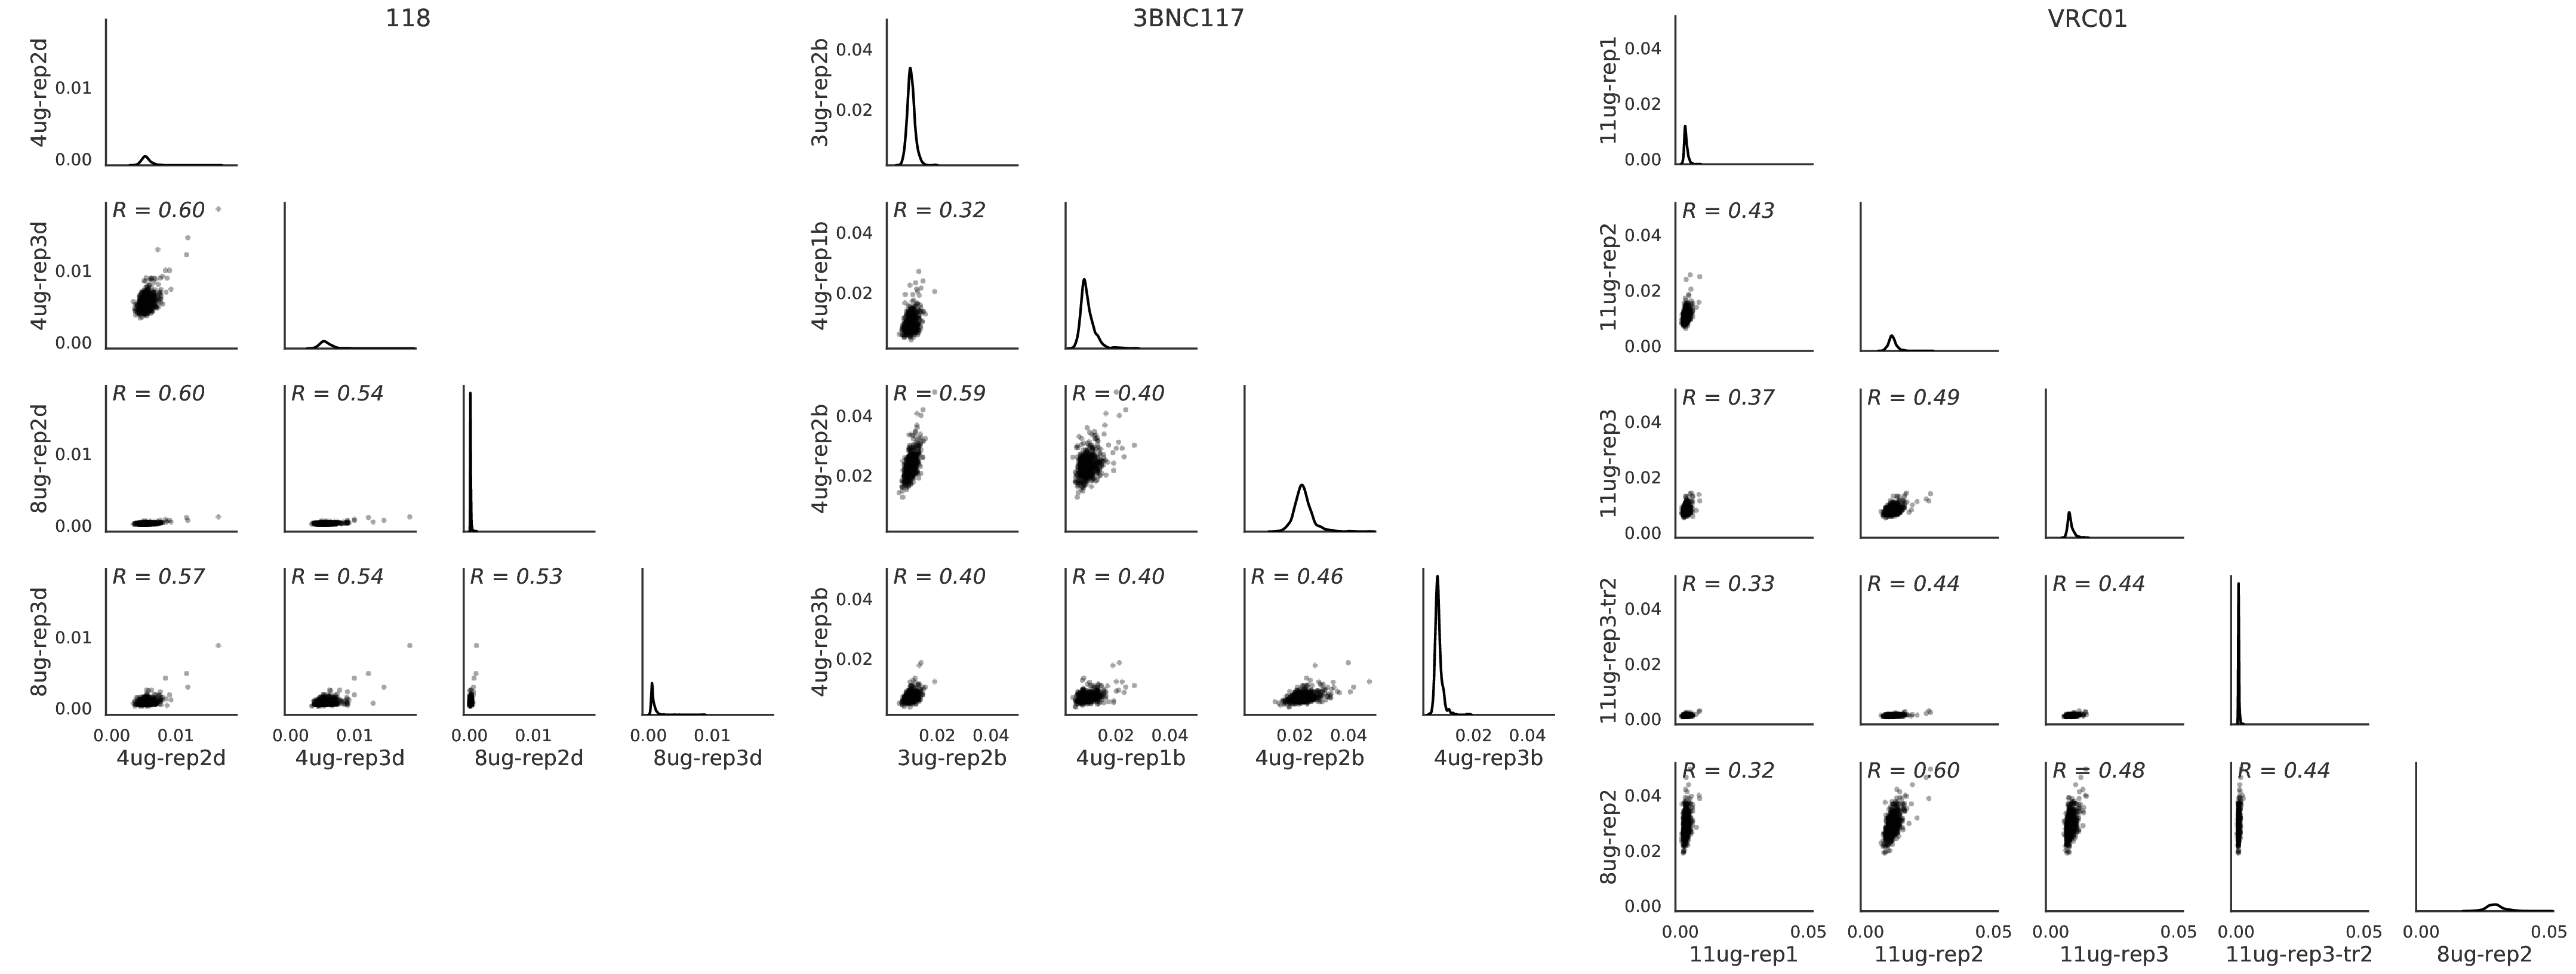


maxfracsurvive correlations:


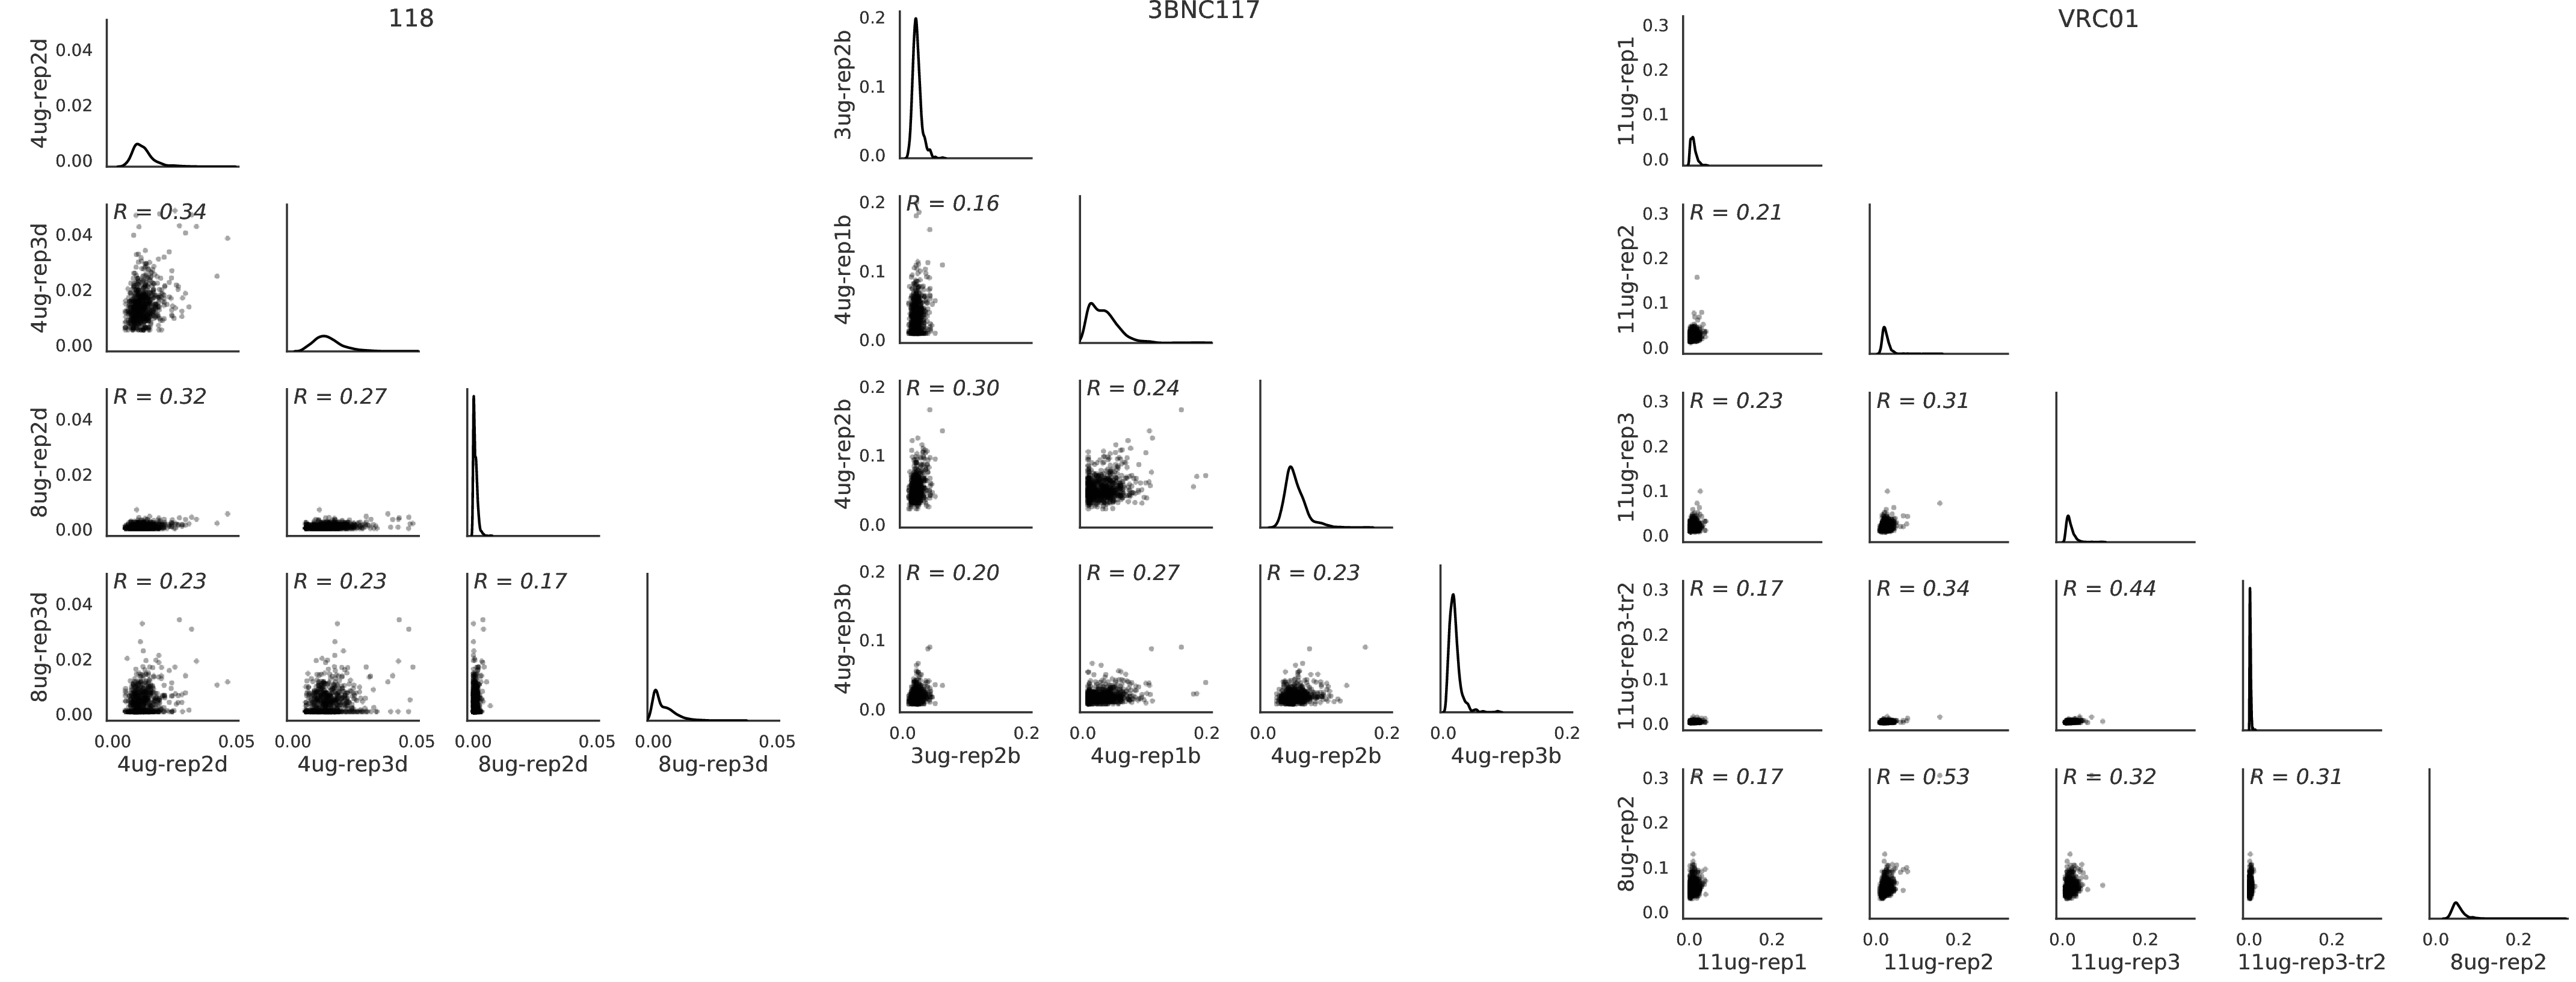

In [24]:
for seltype in ['avgfracsurvive', 'maxfracsurvive']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = fracsurviveprefix + g + '-' + seltype + 'corr.pdf'
        if os.path.isfile(plot):
            plots.append(plot)
        else:
            print("{0} does not exist.".format(plot))
    showPDF(plots, width=1800)

Next, we can look at the correlation for the `fraction surviving above average` values.


avgfracsurvive correlations:


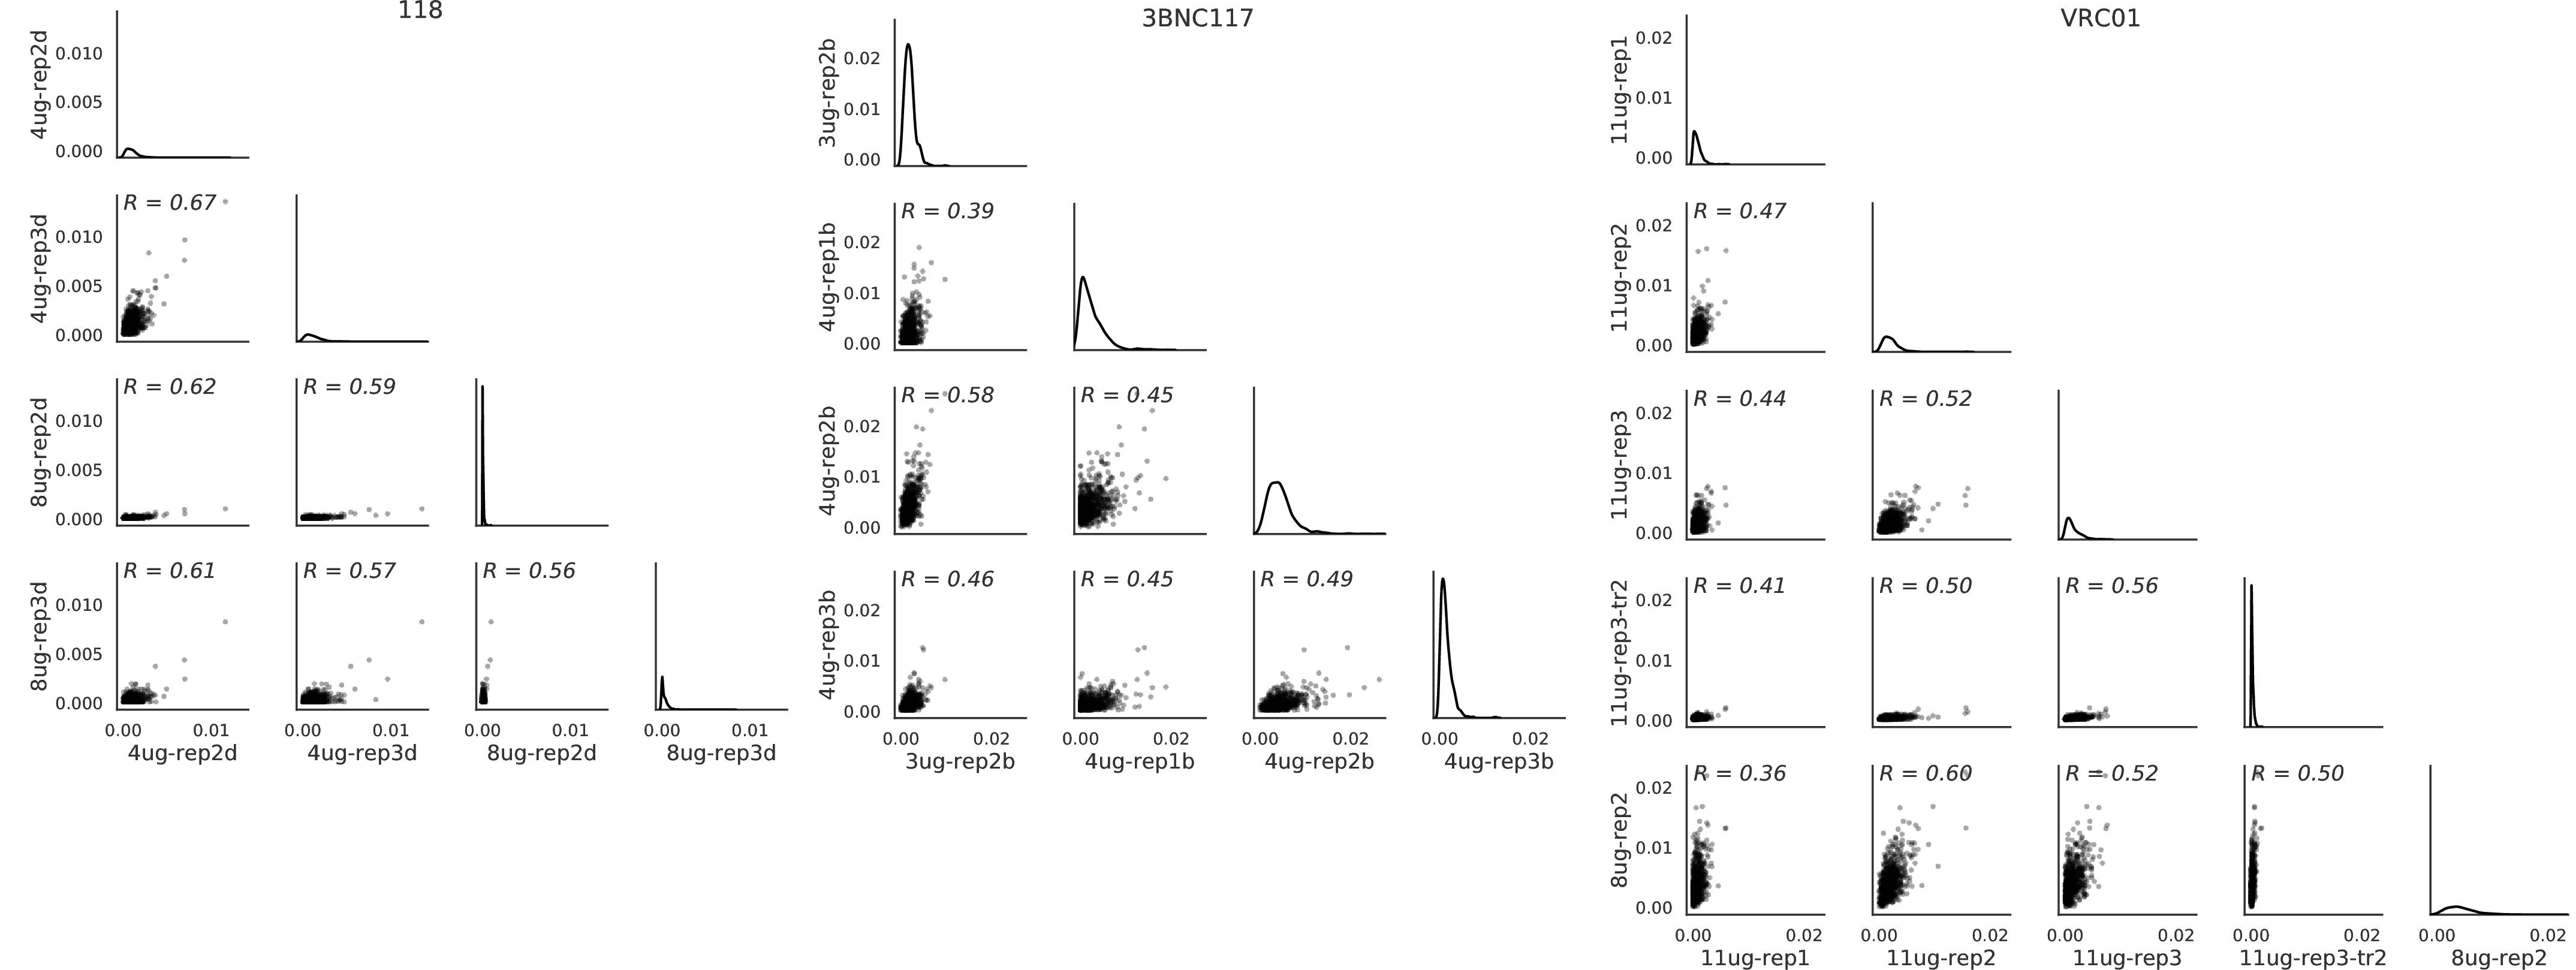


maxfracsurvive correlations:


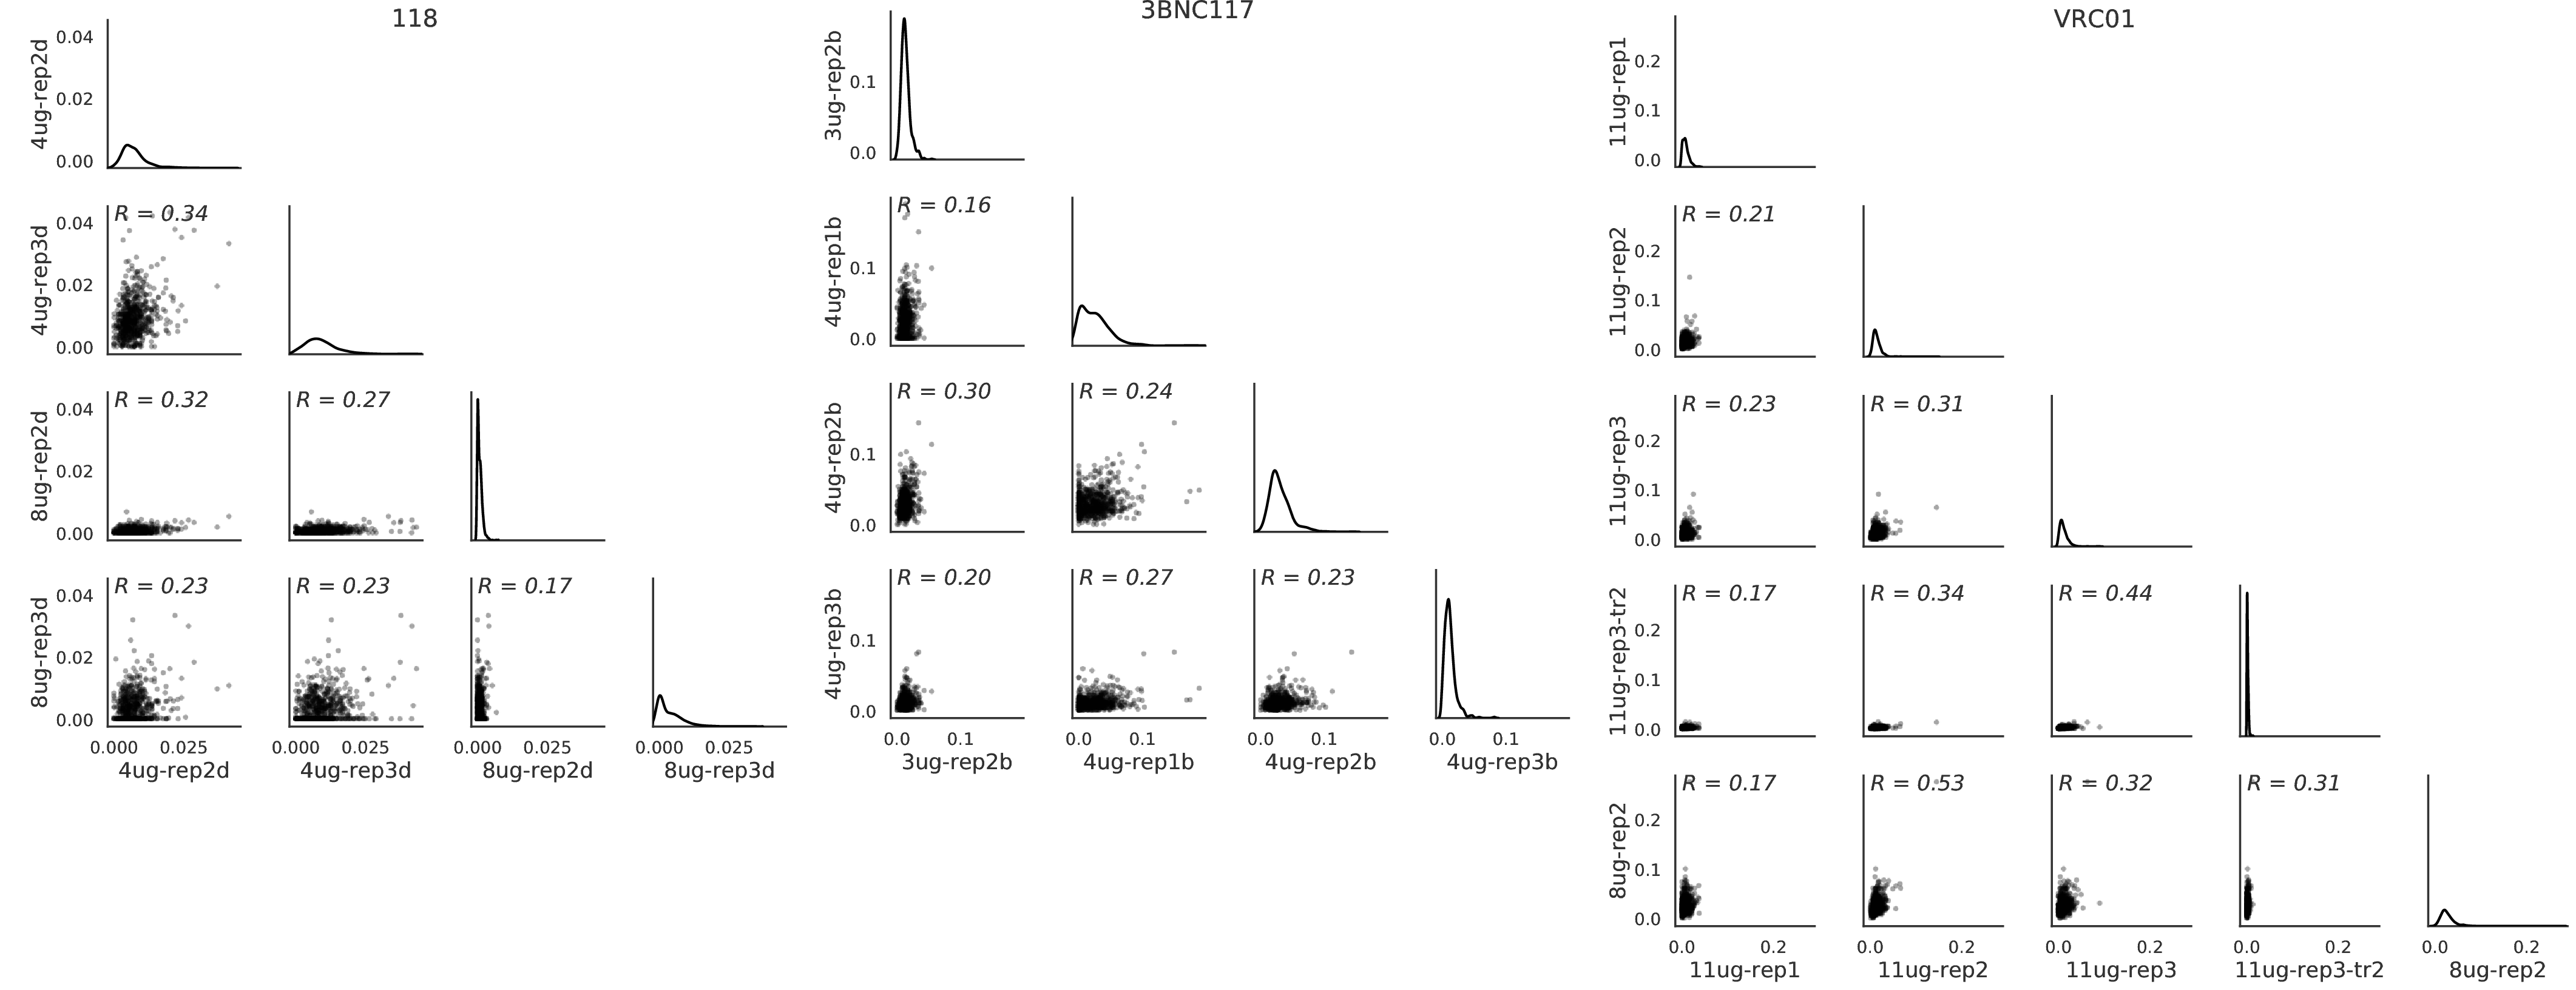

In [25]:
fracsurviveaboveavgprefix = os.path.join(fracsurviveaboveavgdir, 'summary_')

for seltype in ['avgfracsurvive', 'maxfracsurvive']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = fracsurviveaboveavgprefix + g + '-' + seltype + 'corr.pdf'
        if os.path.isfile(plot):
            plots.append(plot)
        else:
            print("{0} does not exist.".format(plot))
    showPDF(plots, width=1800)

Now, lets look at the median `average fraction suurviving above average` for each antibody.

In [26]:
phiaboveavg_sub_tuple = [
 ('1-18', './results/fracsurviveaboveavg/summary_118-mediansitefracsurvive.csv'),#]
 ('VRC01', './results/fracsurviveaboveavg/summary_VRC01-mediansitefracsurvive.csv'),
 ('3BNC117', './results/fracsurviveaboveavg/summary_3BNC117-mediansitefracsurvive.csv')]

names = []
diffselfiles = []
phiaboveavg_dict = {}
for tup in phiaboveavg_sub_tuple:
    names.append(tup[0])
    diffselfiles.append(tup[1])
    phiaboveavg_dict[tup[0]] = tup[1]

In [27]:
import warnings
warnings.filterwarnings('ignore')

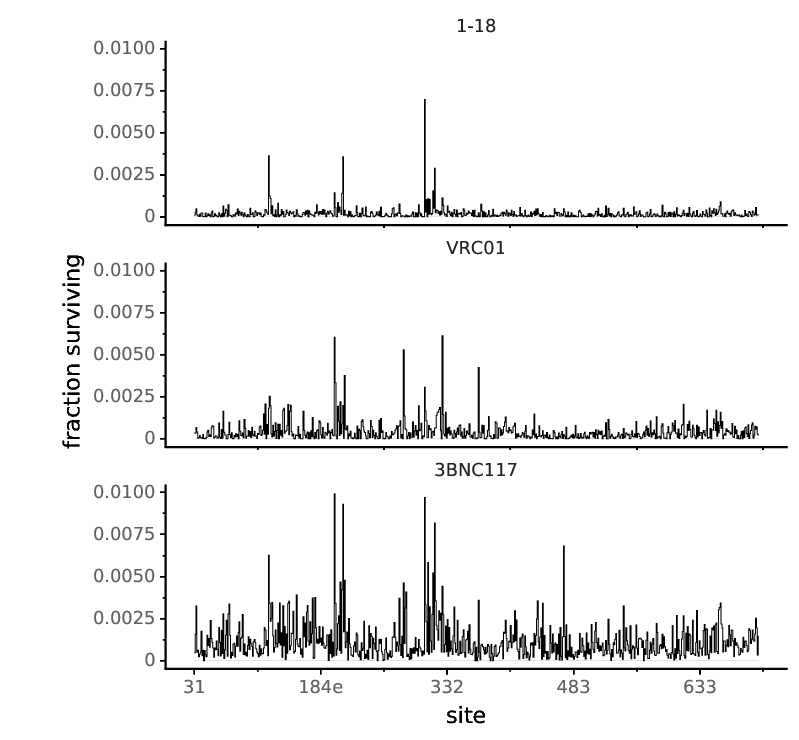

In [28]:
diffseltype = "avgfracsurvive"
plotfile = "./results/fracsurviveaboveavg/CD4bsAb_subset_median_avgsitefracsurvive.pdf"
dms_tools2.plot.plotSiteDiffSel(names, diffselfiles, plotfile, diffseltype, maxcol=1, white_bg=True)
showPDF(plotfile)

In [29]:
groups = fracsurvivebatch['group'].unique()
print(groups)

['118' '3BNC117' 'VRC01']


In [30]:
for antibody in groups:
    mutdiffsel = os.path.join(fracsurviveaboveavgdir, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(fracsurviveaboveavgdir, '{0}-median_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving above avg = {0}"'.format(scaleunit)
    logoname = '{0}-median'.format(antibody)
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {fracsurviveaboveavgdir} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)
    
    mutdiffsel = os.path.join(fracsurvivedir, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(fracsurvivedir, '{0}-median_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving = {0}"'.format(scaleunit)
    logoname = '{0}-median'.format(antibody)
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {fracsurvivedir} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)

Creating logo plot for 118 from ./results/fracsurviveaboveavg/summary_118-medianmutfracsurvive.csv
Creating logo plot for 118 from ./results/fracsurvive/summary_118-medianmutfracsurvive.csv
Creating logo plot for 3BNC117 from ./results/fracsurviveaboveavg/summary_3BNC117-medianmutfracsurvive.csv
Creating logo plot for 3BNC117 from ./results/fracsurvive/summary_3BNC117-medianmutfracsurvive.csv
Creating logo plot for VRC01 from ./results/fracsurviveaboveavg/summary_VRC01-medianmutfracsurvive.csv
Creating logo plot for VRC01 from ./results/fracsurvive/summary_VRC01-medianmutfracsurvive.csv


The overall effect size of mutations at the site under strongest selection is larger for 1-18 than 3BNC117 or VRC01 when examining differential selection. However, there is still lesse selection at the cannonically defined CD4bs. 

I will focus onescess fraction surviving in the paper, as there is not an a priori reason to use one or the other Also, for 3BNC117 and VRC01, there were replicates that were not neutralized as stringently as the 1-18 replicates.  

## Identifying significant escape sites.
As explained by Jesse [here](https://github.com/jbloomlab/computational_notebooks/blob/master/jbloom/2018/MAP_Identifying_Significant_Escape/analysis_notebook.ipynb), we will use [dms_tools2.plot.findSigSel](https://jbloomlab.github.io/dms_tools2/dms_tools2.plot.html#dms_tools2.plot.findSigSel) to fit a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) to binned `avgfracsurvive` values for each antibody using robust regression. We then identify sites that are larger than expected from this distribution at an FDR=0.01. These are significantly higher than expected from a gamma-fit distribution. 

In [31]:
phiaboveavg_sub_tuple = [
 ('118', './results/fracsurviveaboveavg/summary_118-mediansitefracsurvive.csv'),
 ('VRC01', './results/fracsurviveaboveavg/summary_VRC01-mediansitefracsurvive.csv'),
 ('3BNC117', './results/fracsurviveaboveavg/summary_3BNC117-mediansitefracsurvive.csv')]

In [32]:
antibodies = []
datafiles = []
for tup in phiaboveavg_sub_tuple:
    antibodies.append(tup[0])
    datafiles.append(tup[1])

fitresultsdir = './results/fracsurvive/SignificantEscape/'
if not os.path.isdir(fitresultsdir):
    os.mkdir(fitresultsdir)
    

def sigSitesDisplay(valcol, fdrs, antibodies, datafiles):
    """Display the significant sites at some FDRs.
    
    Args:
        `valcol` (str): column to use, `maxfracsurvive` or `avgfracsurvive`
        `fdr` (float): FDR
        `antibodies` (list): antibody names
        `datafiles` (list): sitefracsurvive files
    """
    
    for (a, datafile) in zip(antibodies, datafiles):
        print("\n*************************\nAnalyzing antibody {0}".format(a))
        plots = []
        df_printed = True
        for fdr in sorted(fdrs, reverse=True):
            plot = os.path.join(fitresultsdir, '{0}_{1}_{2}_fit.pdf'.format(a, valcol, fdr))
            df = dms_tools2.plot.findSigSel(
                    pd.read_csv(datafile),
                    valcol,
                    plot,
                    fdr=fdr,
                    title='{0} at FDR {1}'.format(a, fdr),
                    )[0]
            plots.append(plot)
            if not df_printed:
                print(df.query('sig').sort_values('Q')[['site', valcol, 'Q']]
                        .reset_index(drop=True))
                df_printed = True # only print for lowest FDR

        showPDF(plots, width=400)

sigsites = {}
def sigSitesDisplaySave(valcol, fdrs, antibodies, datafiles, sigsitedict):
    """Display the significant sites at a single FDR, and saves that list of sites to s dictionary keyed by antibody
    
    Args:
        `valcol` (str): column to use, `maxfracsurvive` or `avgfracsurvive`
        `fdr` (float): FDR
        `antibodies` (list): antibody names
        `datafiles` (list): sitefracsurvive files
    """
    
    for (a, datafile) in zip(antibodies, datafiles):
        print("\n*************************\nAnalyzing antibody {0}".format(a))
        plots = []
        df_printed = False
        for fdr in sorted(fdrs, reverse=True):
            if  len(fdrs)>1:
                raise NameError('only 1 FDR allowed for this function')
            else:
                plot = os.path.join(fitresultsdir, '{0}_{1}_{2}_fit.pdf'.format(a, valcol, fdr))
                df = dms_tools2.plot.findSigSel(
                        pd.read_csv(datafile),
                        valcol,
                        plot,
                        fdr=fdr,
                        title='{0} at FDR {1}'.format(a, fdr),
                        )[0]
                plots.append(plot)
                if not df_printed:
                    print(df.query('sig').sort_values('Q')[['site', valcol, 'Q']]
                            .reset_index(drop=True))
                    df_printed = True # only print for lowest FDR
                    siglist = df.query('sig')['site'].tolist()
                    
                    print(siglist)
                    sigsitedict[a] = siglist
        showPDF(plots, width=400)

In [33]:
notaboveavgdatafiles =[]
for file in datafiles:
    mutfile = file.replace("aboveavg","")
    notaboveavgdatafiles.append(mutfile)

First we look fo sites of significant escape using the `avgfracsurvive` for a site.


We also print the Q-values for all sites found at even the most lenient FDR: the Q values are the minimum FDR at which each site would be called:



*************************
Analyzing antibody 118
  site  avgfracsurvive             Q
0  304        0.010021  4.097188e-16
1  119        0.006338  9.844564e-06
2  207        0.006232  1.234732e-05
3  318        0.005310  1.667233e-03
['304', '119', '207', '318']


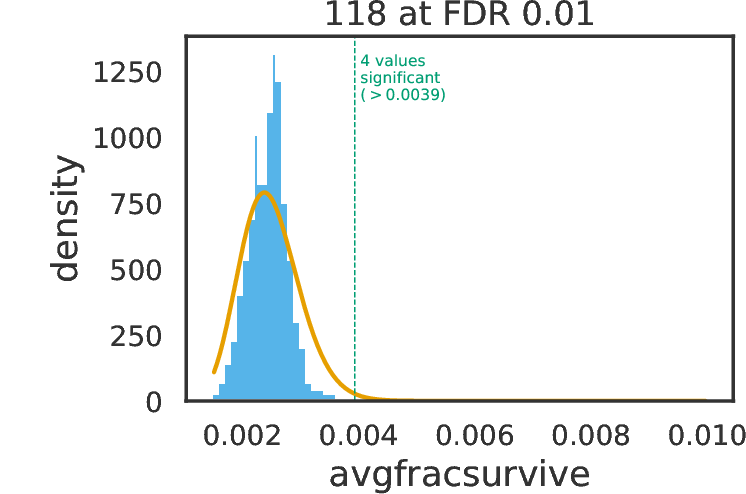


*************************
Analyzing antibody VRC01
  site  avgfracsurvive         Q
0  279        0.013127  0.000001
1  326        0.012705  0.000004
2  369        0.012131  0.000036
3  197        0.011616  0.000227
4  209        0.011280  0.000693
['279', '326', '369', '197', '209']


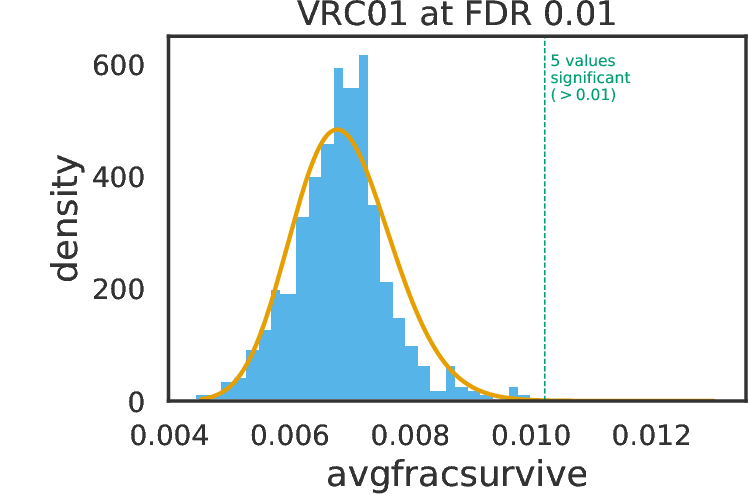


*************************
Analyzing antibody 3BNC117
   site  avgfracsurvive             Q
0   207        0.020230  1.441091e-14
1   304        0.019376  7.440499e-13
2   197        0.017588  4.181925e-09
3   318        0.017310  1.170851e-08
4   471        0.016126  1.884601e-06
5   279        0.015686  9.857346e-06
6   119        0.015012  1.216440e-04
7   308        0.014894  1.597877e-04
8   209        0.014873  1.597877e-04
9   206        0.014474  6.223021e-04
10  182        0.014292  1.075935e-03
11  120        0.014017  2.489072e-03
12  204        0.013997  2.489072e-03
13  369        0.013947  2.734806e-03
14  274        0.013707  5.587751e-03
['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']


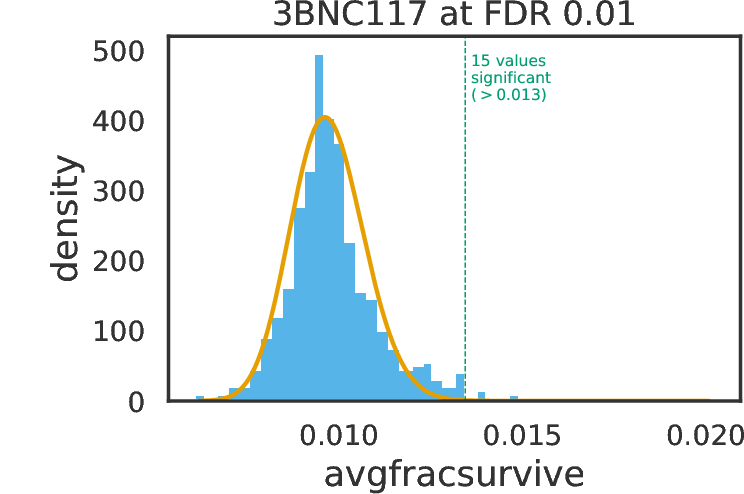

In [34]:
sigsites = {}
fdrs = [0.01]
sigSitesDisplaySave('avgfracsurvive', fdrs, antibodies, notaboveavgdatafiles, sigsites)

Now, lets look at the significant sites of escape in a single table.

In [35]:
print(sigsites)

{'118': ['304', '119', '207', '318'], 'VRC01': ['279', '326', '369', '197', '209'], '3BNC117': ['207', '304', '197', '318', '471', '279', '119', '308', '209', '206', '182', '120', '204', '369', '274']}


In [36]:
from natsort import natsorted
sigsitestabledict = {}
for ab in sigsites.keys():
    sitelist = sigsites[ab]
    sortedsitelist = natsorted(sitelist)
    sitestring = ', '.join(sortedsitelist)
    sigsitestabledict[ab] = sitestring


sigsitestable = pd.DataFrame.from_dict(sigsitestabledict, orient='index')
with pd.option_context('display.max_colwidth', -1): 
    display(HTML(sigsitestable.to_html(index=True)))

,0
118,"119, 207, 304, 318"
VRC01,"197, 209, 279, 326, 369"
3BNC117,"119, 120, 182, 197, 204, 206, 207, 209, 274, 279, 304, 308, 318, 369, 471"


In [37]:
fracsurviveaboveavg_dict = {}
fracsurviveaboveavg_dict["118"] = "./results/fracsurviveaboveavg/summary_118-medianmutfracsurvive.csv"

fracsurviveaboveavg_dict["VRC01"] = "./results/fracsurviveaboveavg/summary_VRC01-medianmutfracsurvive.csv"
fracsurviveaboveavg_dict["3BNC117"] = "./results/fracsurviveaboveavg/summary_3BNC117-medianmutfracsurvive.csv" 
fracsurviveaboveavg_dict["101074"] = "./results/fracsurviveaboveavg/summary_101074-medianmutfracsurvive.csv"

sitefracsurviveaboveavg_dict = {}
sitefracsurviveaboveavg_dict["118"] = "./results/fracsurviveaboveavg/summary_118-mediansitefracsurvive.csv"
sitefracsurviveaboveavg_dict["VRC01"] = "./results/fracsurviveaboveavg/summary_VRC01-mediansitefracsurvive.csv" 
sitefracsurviveaboveavg_dict["3BNC117"] = "./results/fracsurviveaboveavg/summary_3BNC117-mediansitefracsurvive.csv"
sitefracsurviveaboveavg_dict["101074"] = "./results/fracsurviveaboveavg/summary_101074-mediansitefracsurvive.csv"


In [38]:
import seaborn as sns
from scipy import stats
%matplotlib inline

## Generate figure ready plots 
Now, I will replot the data in a number of ways for paper figures. 

In [39]:
summplotdir = "./results/fracsurviveaboveavg/SummaryPlots/"
if not os.path.isdir(summplotdir):
    os.mkdir(summplotdir)

In [40]:
import re
import os
import math
import natsort
#import pandas
import numpy
import scipy.stats
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import rc
from plotnine import *
# set ggplot theme
theme_set(theme_bw(base_size=12)) 

import seaborn


from dms_tools2 import CODONS, AAS, AAS_WITHSTOP
import dms_tools2.utils
COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

def plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, 
        diffseltype, y_lim=None, highlighted_sites =[], underlay_1 = [], point = [], maxcol=2, white_bg=False):
    """Plot site diffsel or fracsurvive along sequence.
    Despite the function name, this function can be used to
    plot either differential selection or fraction surviving.
    Args:
        `names` (list or series)
            Names of samples for which we plot statistics.
        `diffselfiles` (list or series)
            ``*sitediffsel.csv`` files from ``dms2_diffsel`` or
            ``*sitefracsurvive.csv`` files from ``dms2_fracsurvive``.
        `plotfile` (str)
            Name of created PDF plot file.
        `diffseltype` (str)
            Type of diffsel or fracsurvive to plot:
                - `positive`: positive sitediffsel
                - `total`: positive and negative sitediffsel
                - `max`: maximum mutdiffsel
                - `minmax`: minimum and maximum mutdiffsel
                - `avgfracsurvive`: total site fracsurvive
                - `maxfracsurvive`: max mutfracsurvive at site
        `maxcol` (int)
            Number of columns in faceted plot.
        `white_bg` (bool)
            Plots will have a white background with limited other formatting.
            
        DOCUMENT CHANGES
    """
    assert len(names) == len(diffselfiles) == len(set(names)) > 0
    assert os.path.splitext(plotfile)[1].lower() == '.pdf'

    diffsels = [pd.read_csv(f).assign(name=name) for (name, f) 
            in zip(names, diffselfiles)]
    assert all([set(diffsels[0]['site']) == set(df['site']) for df in 
            diffsels]), "diffselfiles not all for same sites"
    diffsel = pd.concat(diffsels, ignore_index=True)

    ylabel = 'differential selection'
    if diffseltype == 'positive':
        rename = {'positive_diffsel':'above'}
    elif diffseltype == 'total':
        rename = {'positive_diffsel':'above',
                  'negative_diffsel':'below'}
    elif diffseltype == 'max':
        rename = {'max_diffsel':'above'}
    elif diffseltype == 'minmax':
        rename = {'max_diffsel':'above',
                  'min_diffsel':'below'}
    elif diffseltype in ['avgfracsurvive', 'maxfracsurvive']:
        ylabel = 'fraction surviving'
        rename = {diffseltype:'above'}
    else:
        raise ValueError("invalid diffseltype {0}".format(diffseltype))
    diffsel = (diffsel.rename(columns=rename)
                      .melt(id_vars=['site', 'name'], 
                            value_vars=list(rename.values()),
                            value_name='diffsel',
                            var_name='direction')
                      )


    # natural sort by site: https://stackoverflow.com/a/29582718
    diffsel = diffsel.reindex(index=natsort.order_by_index(
            diffsel.index, natsort.index_natsorted(diffsel.site)))#,
            #signed=True)))
    # now some manipulations to make site str while siteindex is int
    diffsel['site'] = diffsel['site'].apply(str)
    diffsel['siteindex'] = pd.Categorical(diffsel['site'],
            diffsel['site'].unique()).codes
    
    ncol = min(maxcol, len(names))
    nrow = math.ceil(len(names) / float(ncol))
    y_lim_min = y_lim - (float(y_lim/30))

    # make name a category to preserve order
    diffsel['name'] = diffsel['name'].astype('category')#, 
            #categories=names)
    
    (xbreaks, xlabels) = dms_tools2.plot.breaksAndLabels(diffsel['siteindex'].unique(), 
            diffsel['site'].unique(), n=6)
    
    #diffsel['highlight'] = diffsel['site'].isin(highlighted_sites) 
    #diffsel['highlight'] =np.where(diffsel['highlight']==True , -0.0092, -1)#-0.0092, -1)#-1)
    diffsel['highlight'] = diffsel['site'].isin(highlighted_sites) 
    diffsel['highlight'] =np.where(diffsel['highlight']==True , y_lim, -1)
    #diffsel['underlay_1'] = 0.16
    diffsel['underlay_1'] = diffsel['site'].isin(underlay_1)
    #worksforunderlaydiffsel['underlay_1'] =np.where(diffsel['underlay_1']==True , -0.003, -1) #0, -1) #last two things are height and bottom
    ymin = float(y_lim) *(float(.005/.15))*float(-1)
    diffsel['underlay_1'] =np.where(diffsel['underlay_1']==True , ymin, -1)
    diffsel['point'] = diffsel['site'].isin(point)
    diffsel['point'] =np.where(diffsel['point']==True , -0.0069, -1)
    #diffsel['point'] =np.where(diffsel['point']==True , diffsel['diffsel'], -1)
    #this will do an overlay diffsel['underlay_2'] =np.where(diffsel['underlay_2']==True , y_lim, -1) #last two things are height and bottom

    
    

    if white_bg:
        p = (ggplot(diffsel, aes(x='siteindex', y='diffsel',
                    color='direction', fill='direction'))             
             + geom_bar(aes(y='highlight'), alpha=0.0, stat="identity", color="#d8d8d8", size=0.5, show_legend=False) #pink was #ECBABA
             + geom_step(size=0.5) #was .3
             + geom_point(aes(y='underlay_1'), fill="#0000e1", shape="|", size=3, show_legend=False) #light blue - #0072b2 old color: "#440154ff"             
             + scale_y_continuous(limits=(ymin, y_lim))#-0.0092, y_lim))
             + xlab('site')
             + ylab(ylabel)
             + scale_x_continuous(breaks=xbreaks, labels=xlabels)
             + scale_color_manual(COLOR_BLIND_PALETTE)
             + scale_fill_manual(COLOR_BLIND_PALETTE)
             + guides(color=False)
             + theme(#panel_background=element_rect(fill='white'),
                     axis_line_x=element_line(color='black'),
                     axis_line_y=element_line(color='black'),
                     axis_title_x=element_blank(),
                     axis_title_y=element_blank(),
                     panel_grid=element_blank(),
                     panel_border=element_blank(),
                     strip_background=element_blank()
                     )
            )
    else:
        p = (ggplot(diffsel, aes(x='siteindex', y='diffsel', color='direction'))
             + geom_step(size=0.4)
             + xlab('site')
             + scale_y_continuous(limits=(0, y_lim))
             + ylab(ylabel)
             + scale_x_continuous(breaks=xbreaks, labels=xlabels)
             + scale_color_manual(COLOR_BLIND_PALETTE)
             + guides(color=False)
             )
    if not ((len(names) == 1) and ((not names[0]) or names[0].isspace())):
        p += facet_wrap('~name', ncol=ncol)
    p += theme(figure_size=(8 * (0.3 + ncol), 1.5 * (0.2 + nrow))) #WAS 4.6  and 1.9
    p.save(plotfile, verbose=False, transparent=True)
plt.close()

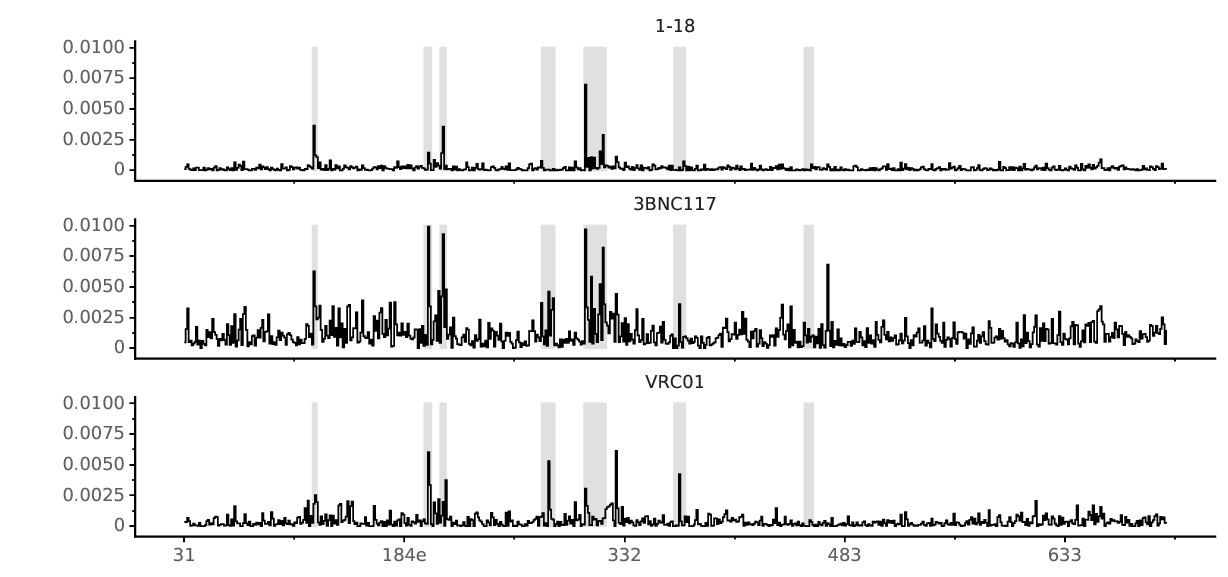

In [41]:
CD4bs_sites_sub = ['119', '120', '121', "195", "196",'197', '198', '199', '206','207', '208', '209', '275', '276', '277', '278', '279', '280', '281', '282', '283', '304', '305', '306', '307', '308', '309', '310', '311','312','313','314','315', '316', '317', '318', '319', '320', '366', '367', '368', '369', '370', '371', '372', '373', '456', '457', '458', '459', '460', '461']
antibodies = ['1-18', 'VRC01', '3BNC117']

diffseltype = "avgfracsurvive"
plotfile = "./results/fracsurviveaboveavg/CD4bsAb_overlay_median_avgsitefracsurvive.pdf"
ylimit=0.01
plotSiteDiffSel_YLimDiff(antibodies, diffselfiles, plotfile, diffseltype, highlighted_sites = CD4bs_sites_sub, y_lim=ylimit, maxcol=1, white_bg=True)
showPDF(plotfile)

## Make logoplots of key sites
Here, I will plot two sets of sites for each antibody. 

First, I plot the `fraction surviving above average`, `BG505 rescaled preferencs`, and the `frequency in nature` for **structurally defined contact sites**. These figures are not in the paper, but I speculate that some people (like me) will love to examine how these three metrics compare in the epitope of different antibodies. 

Next, I will plot the `fraction surviving above average` for **"sites of interest"** for each epitope. These groups of sites are defined above loosely based on contact sites, sites of significant escape, and prior literature for each antibody that targets that epitope. They are the sites shown in the paper figures. 

In [42]:
epitopelogodir = os.path.join(resultsdir, 'fracsurviveaboveavg/EpitopeLogoplots/')
if not os.path.isdir(epitopelogodir):
    os.mkdir(epitopelogodir)

In [43]:
import phydmslib.weblogo
AA_COLORS_FG = phydmslib.weblogo.FunctionalGroupColorMapping()[1]

def siteSubsetGGSeqLogo(logodata, chars, plotfile, width, height,
        yname='', char_colors=AA_COLORS_FG, ylimits=None):
    """Creates one-row logo plot with subset of sites.
    Designed to show logo plot for a subset of sites. This
    is useful when you have data for many sites, but only
    want to look at a few of them. 
    Args:
        `logodata` (pandas DataFrame)
            Contains data to plot. Should have the columns
            `site`, `show`, and a column giving the height
            height of each char in `chars`. Only sites
            where `show` is `True` are shown. Sites are 
            shown in the order they occur in this dataframe,
            with spaces every time there is an interspersed
            site with `show` being `False`. 
        `chars` (list)
            Letters for which we plot heights.
        `plotfile` (str)
            Name of created plot.
        `width` (float)
            Width of plot in inches.
        `height` (float)
            Height of plot in inches.
        `yname` (str)
            If set to a non-empty string, is the y-axis label
            and yticks are drawn.
        `char_colors` (dict)
            Values give color for every character in `chars`.
        `ylimits` (`None` or 2-tuple)
            If not `None`, should give the ylimits for the plot
            as `(ymin, ymax)`
    Here is an example that creates a plot for a subset of
    sites for two characters:
    >>> logodata = pandas.read_csv(io.StringIO(
    ...     '''site show    A    C
    ...        A101 True  0.8  0.2
    ...        N102 True  0.7  0.3
    ...        K103 False 0.1  0.9
    ...        L104 True  0.8  0.2
    ...        S105 True  0.5  0.5
    ...        T106 False 0.2  0.8
    ...        G107 False 0.4  0.6
    ...        L108 True  0.7  0.3'''),
    ...     delim_whitespace=True, index_col=False)
    >>> plotfile = '_siteSubsetGGSeqLogo_test_plot.png'
    >>> siteSubsetGGSeqLogo(logodata,
    ...         chars=['A', 'C'],
    ...         plotfile=plotfile,
    ...         width=3.5, height=2
    ...         )
    >>> os.path.isfile(plotfile)
    True
    Here is the plot created by the code block above:
    .. image:: _static/_siteSubsetGGSeqLogo_test_plot.png
       :width: 55%
       :align: center
    """
    if os.path.isfile(plotfile):
        os.remove(plotfile)

    assert set(chars) <= set(char_colors.keys()), \
            "`char_colors` not defined for all chars"

    expectcol = ['site', 'show'] + chars
    assert set(logodata.columns) >= set(expectcol), \
            "`logodata` needs these column: {0}".format(expectcol)

    assert logodata['show'].any(), "no sites to show"

    # for each consecutive set of rows not to show, keep just one
    logodata = logodata[expectcol]
    logodata['keeprow'] = (
            ((logodata['show']) | 
                (logodata['show'] != logodata['show'].shift(1)))
            )
    logodata = logodata.query('keeprow').reset_index()

    # trim first and last row if they are not to be shown
    if not logodata.iloc[0]['show']:
        logodata = logodata.iloc[1 : ].reset_index()
    if not logodata.iloc[-1]['show']:
        logodata = logodata.iloc[ : -1]

    # set site label to empty and data to zero for rows not to show
    logodata.loc[~logodata['show'], 'site'] = ''
    logodata.loc[~logodata['show'], chars] = 0
    vertlines = logodata.query('~show').index.values + 1

    # generate matrix to plot
    sites = logodata['site']
    matrix = r.matrix(logodata.set_index('site')[chars].values.ravel(),
            ncol=len(sites),
            dimnames=[chars, sites]
            )

    if ylimits is None:
        ylimits = rinterface.NULL
    else:
        ylimits = FloatVector(ylimits)

    # make the plot
    with warnings.catch_warnings():
        warnings.simplefilter(SHOW_WARNINGS)
        _RFUNCS.siteSubsetGGSeqLogo(
                mat=matrix,
                plotfile=plotfile,
                width=width,
                height=height,
                xlabels=list(map(str, sites)),
                vertlines=vertlines,
                yname=yname,
                chars=StrVector(chars),
                char_colors=StrVector([char_colors[x] for x in chars]),
                ylimits=ylimits
                )

    if not os.path.isfile(plotfile):
        raise RuntimeError("failed to create {0}".format(plotfile))

### munge the LANL sequence alignment
`HIV1_FLT_2016_env_PRO.fasta` is the filtered web alignment of all HIV-1 sequences, downoaded Jan 3, 2018 from [`LANL`](https://www.hiv.lanl.gov/cgi-bin/NEWALIGN/align.cgi). We convert the alignment with the function below to amino acid frequencies. 
[./data/HXB2_HIV1_FLT_2016_env_PRO_numbering.csv](./data/HXB2_HIV1_FLT_2016_env_PRO_numbering.csv) is a csv file that contains the HXB2 sequence from the alignment (containing the insertions), with the site labeled according to it's site in the alingment. 
["./data/HXB2_alignment_to_HXB2.csv](./data/HXB2_alignment_to_HXB2.csv) contains a conversion between the alignment site and the HXB2 site. note that insertions sites relative to HXB2 are labled with an x rather than the actual notation (i.e. a, b etc). 

In [44]:
#here, I am redefining dms_tools2.prefs.aafreqsFromAlignment such that it gets rid of sequences that:
#are not the same length 
#mask sites that not IUPAC AAs. 
import Bio.SeqIO
def aafreqsFromAlignment_AD(alignmentfile, codon_to_aa,
        ignore_gaps=True, ignore_stop=True):
    """Get amino-acid frequencies at each site in alignment.

    Args:
        `alignmentfile` (str)
            FASTA file with alignment of proteins or coding sequences.
        `codon_to_aa` (bool)
            If `True`, translate codon alignment to amino acids.
        `ignore_gaps` (bool)
            Ignore gaps when calculating frequencies.
        `ignore_stop` (bool)
            Ignore stop codons when calculating frequencies.

    Returns:
        A `pandas.DataFrame` with columns being `site` (1, 2, ...
        numbering) and other columns being amino acids and values
        giving frequencies in alignment.

    >>> with tempfile.NamedTemporaryFile(mode='w') as f:
    ...     x = f.write('>seq1\\n'
    ...                 'ATGGGGCAG\\n'
    ...                 '>seq2\\n'
    ...                 '---AGGCAG\\n'
    ...                 '>seq3\\n'
    ...                 'ATGTGACAG')
    ...     f.flush()
    ...     aafreqs = aafreqsFromAlignment(f.name, codon_to_aa=True)
    >>> aas_counts = ['M', 'G', 'R', 'Q']
    >>> aas_nocounts = [a for a in dms_tools2.AAS if a not in aas_counts]
    >>> (0 == aafreqs[aas_nocounts].values).all()
    True
    >>> expected_counts = pandas.DataFrame.from_items([
    ...         ('site', [1, 2, 3]), ('M', [1.0, 0.0, 0.0]),
    ...         ('G', [0.0, 0.5, 0]), ('R', [0.0, 0.5, 0.0]),
    ...         ('Q', [0.0, 0.0, 1.0])])
    >>> expected_counts.equals(aafreqs[['site'] + aas_counts])
    True
    """
    # read sequences
    seqs = [s.seq for s in Bio.SeqIO.parse(alignmentfile, 'fasta')]
    if codon_to_aa:
        seqs = [s.translate(gap='-', stop_symbol='*') for s in seqs]
    assert seqs, "No sequences"
    seqlen = len(seqs[0])
    #assert seqlen, "sequences have no length" #commented this and line below out. 
    #assert all([seqlen == len(s) for s in seqs]), "seqs not same length"
    # get character sets
    aas = dms_tools2.AAS.copy()
    skipchars = ["#","?","X","$"] #here I added these other characters
    if ignore_gaps:
        skipchars.append('-')
    else:
        aas.append('-')
    if ignore_stop:
        skipchars.append('*')
    else:
        aas.append('*')
    # tally amino-acid frequencies
    aafreqs = dict([(col, [0] * seqlen) for col in aas])
    aafreqs['site'] = list(range(1, seqlen + 1))
    for s in seqs:
        for (r, aa) in enumerate(s):
            if aa in skipchars:
                continue
            else:
                aafreqs[aa][r] += 1
    # convert to dataframe and change counts to freqs
    aafreqs = pd.DataFrame(aafreqs)
    ncounts = aafreqs[aas].sum(axis=1).astype('float')
    for aa in aas:
        aafreqs[aa] = aafreqs[aa] / ncounts
    return aafreqs[['site'] + aas].fillna(0)

In [45]:
groupM_alignmentfile = "./data/HIV1_FLT_2016_env_PRO.fasta" 
groupM_df = aafreqsFromAlignment_AD(groupM_alignmentfile , codon_to_aa=False, ignore_gaps=True, ignore_stop=True)
alginment_to_HXB2 = pd.read_csv("./data/HXB2_alignment_to_HXB2.csv")
AnnotatedAlignment_df = alginment_to_HXB2.merge(groupM_df, left_on='alignment_site', right_on='site')
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('site', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('HXB2_AA', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('alignment_site', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.rename(columns={'HXB2_site': 'site'})
AnnotatedAlignment_DropInserts_df = AnnotatedAlignment_df[AnnotatedAlignment_df.site.str.contains("x") == False].copy()

In [46]:
import natsort
def EpitopeFracsurviveLogoplot(mutfracsurvivefile, keysites, outfile, max_sitefracsurvive):
    pandadf = pd.read_csv(mutfracsurvivefile)
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutfracsurvive')

    #sort sites 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    df['site'] = df['wildtype'] + df['site']
    width = len(keysites) / 4
    dms_tools2.rplot.siteSubsetGGSeqLogo(
        logodata=df,
        chars=dms_tools2.AAS,
        plotfile=outfile,
        width= width,
        height=2.5,
        yname='frac surviving',
        ylimits=(0,max_sitefracsurvive),
    )
    
def EpitopePrefLogoplot(preffile, keysites, outfile):
    df = pd.read_csv(preffile)
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    #df['site'] = df['wildtype'] + df['site']
    width = len(keysites) / 4
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=outfile,
            width=width,
            height=2,
            yname='preference',
            ylimits=(0,1.1),
            )
    
def EpitopeNatSeqLogoplot(HXB2annotated_df, keysites, outfile):
    df = HXB2annotated_df
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    width = len(keysites) / 4
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=outfile,
            width=width,
            height=2,
            yname='freq in nature',
            ylimits=(0,1.1),
            )

In [47]:
preffile = "./data/BG505-avg-rescaled-prefs_ADrealigned.csv" 

1-18
1-18
Here is the fraction surviving 1-18 at sites of interest


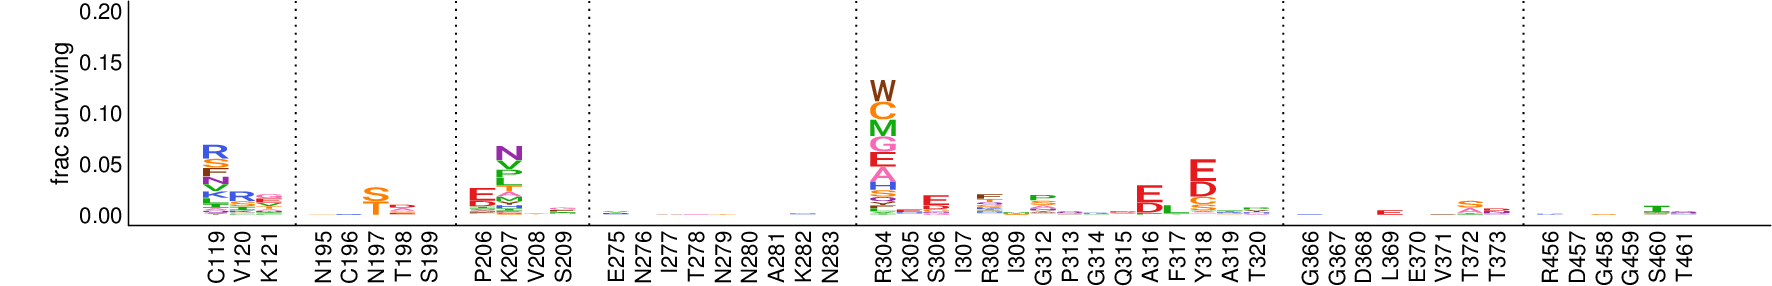

VRC01
VRC01
Here is the fraction surviving VRC01 at sites of interest


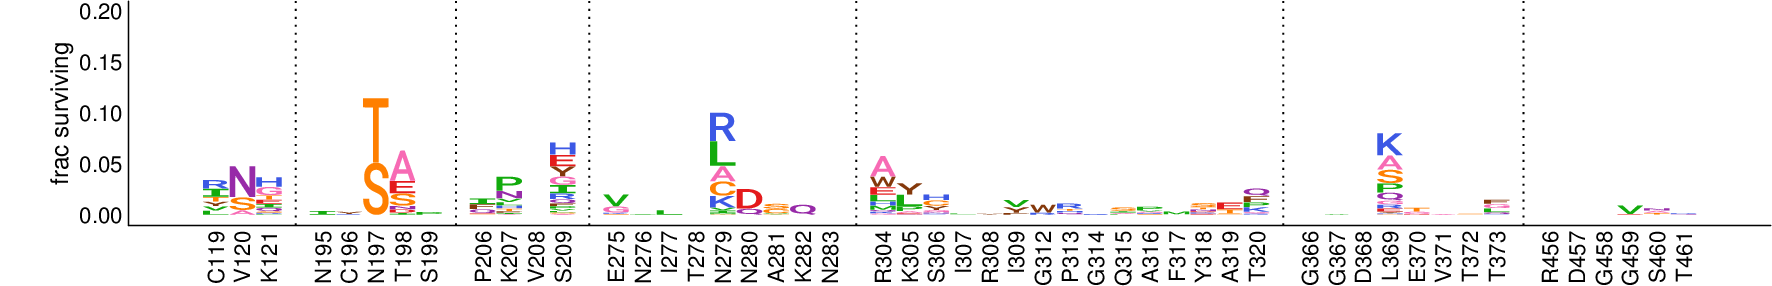

3BNC117
3BNC117
Here is the fraction surviving 3BNC117 at sites of interest


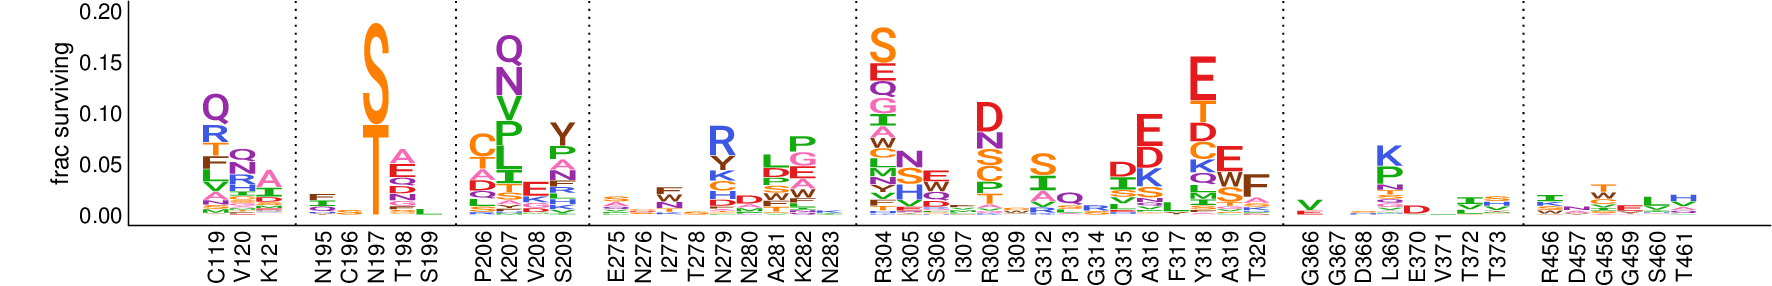

In [48]:
epitopelogodir = os.path.join(resultsdir, 'fracsurviveaboveavg/EpitopeLogoplots/SitesOfInterest/')
if not os.path.isdir(epitopelogodir):
    os.mkdir(epitopelogodir)
    
fracsurviveaboveavg_dict_ug = {}
wtDNActrldict = "./results/fracsurviveaboveavg"
fracsurviveaboveavg_dict_ug["VRC01"] = "./results/fracsurviveaboveavg/summary_VRC01-medianmutfracsurvive.csv" 
fracsurviveaboveavg_dict_ug["3BNC117"] = "./results/fracsurviveaboveavg/summary_3BNC117-medianmutfracsurvive.csv" 
fracsurviveaboveavg_dict_ug["1-18"] = "./results/fracsurviveaboveavg/summary_118-medianmutfracsurvive.csv" 


max_sitefracsurvive_dict = {}
max_sitefracsurvive_dict["VRC01"] = "0.2"
max_sitefracsurvive_dict["3BNC117"] = "0.2"
max_sitefracsurvive_dict["1-18"] = "0.2"



natseq_df = AnnotatedAlignment_DropInserts_df.copy()
for ab in antibodies:
    epitopesites = CD4bs_sites_sub #epitope_sites_of_interest[ab]
    print(ab)
    max_sitefracsurvive = max_sitefracsurvive_dict[ab]
    fracsurvivefile= fracsurviveaboveavg_dict_ug[ab]
    fs_outfile = "{0}/{1}_epitope_fracsurviveaboveavg.pdf".format(epitopelogodir, ab)
    pref_outfile = "{0}/{1}_epitope_prefs.pdf".format(epitopelogodir, ab)
    natseq_outfile = "{0}/{1}_NatSeq.pdf".format(epitopelogodir, ab)
    EpitopeFracsurviveLogoplot("{0}".format(fracsurvivefile), epitopesites, fs_outfile, max_sitefracsurvive)
    EpitopePrefLogoplot(preffile, epitopesites, pref_outfile)
    EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    print(ab)
    print("Here is the fraction surviving {0} at sites of interest".format(ab, ab))
    pdflist = []
    showPDF(fs_outfile)


In [49]:
escapedir = './results/fracsurviveaboveavg/escapability_plots/'
if not os.path.isdir(escapedir):
    os.mkdir(escapedir)

Now, lets compare the largest effect size mutations across antibodies. For each antibody, I will just plot the effect size of the top 100 mutations...

First, I need to get the median excess mut frac survive files from [Dingens et al Immunity 2019](https://www.cell.com/immunity/fulltext/S1074-7613(18)30565-X) for 10-1074 and pooled 10-1074/3BNC117. I did not reanalyze these samples start to finish because they are not included in other samples. 

In [50]:
import requests
 
url = 'https://raw.githubusercontent.com/jbloomlab/EnvsAntigenicAtlas/master/results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_101074-medianmutfracsurvive.csv'
ab101074file = requests.get(url)
open('./results/fracsurviveaboveavg/summary_101074-medianmutfracsurvive.csv', 'wb').write(ab101074file.content)

url = 'https://raw.githubusercontent.com/jbloomlab/EnvsAntigenicAtlas/master/results/fracsurviveaboveavg/concavg_wtDNA_ctrl/summary_3BN-1074-pool-medianmutfracsurvive.csv'
ab3BN101074file = requests.get(url)
open('./results/fracsurviveaboveavg/summary_3BN-1074-pool-medianmutfracsurvive.csv', 'wb').write(ab3BN101074file.content)


183206

all mutations, ranked phi:


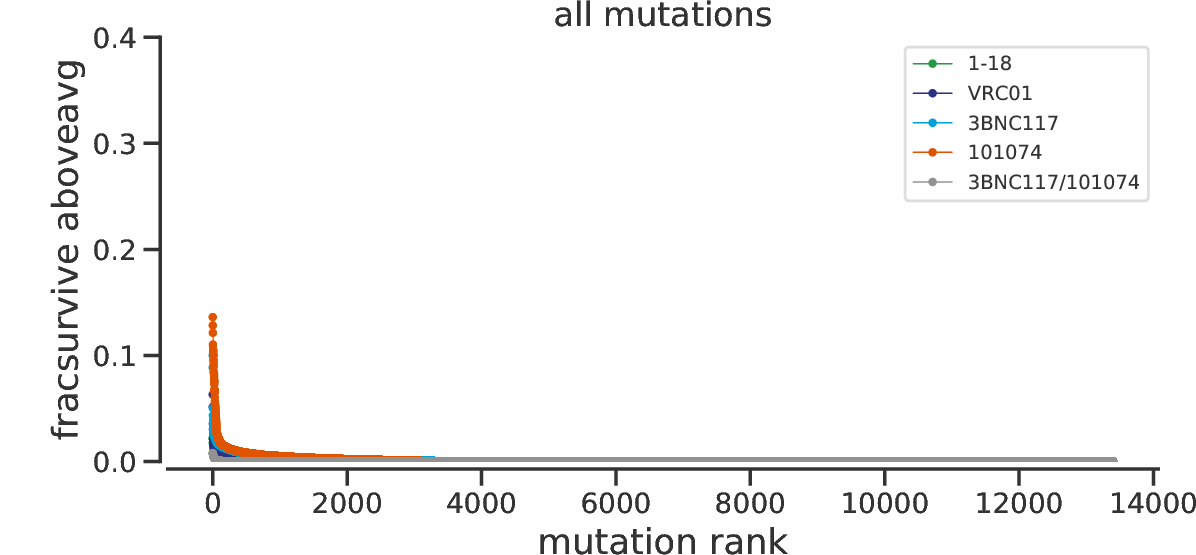

top 1000, ranked phi:
top 100, ranked phi:


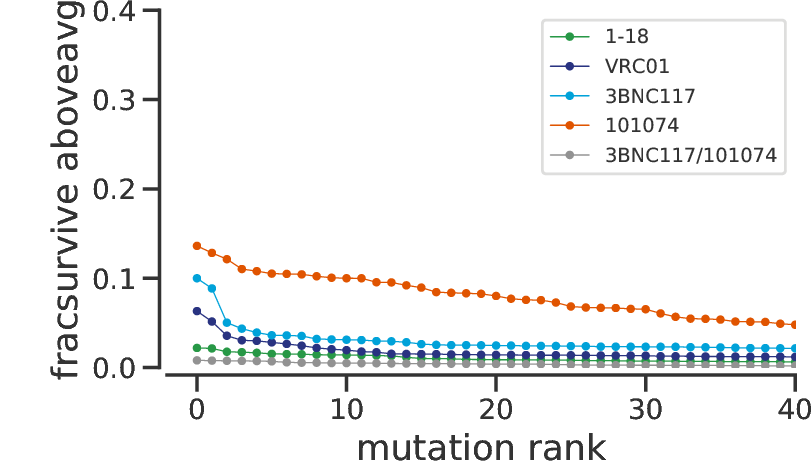

In [51]:
colorcycle = ["#279846", "#293381", "#00a2d9",
             #"#7f2d19", "#c04526",
             #"#eb5e18", "#f5ad8a",
             #"#1da19d", "#53dfdb",
             "#e05400", "#808080"]
phiaboveavg_sub_tuple_mut = [('1-18', './results/fracsurviveaboveavg/summary_118-medianmutfracsurvive.csv'),
    ('VRC01', './results/fracsurviveaboveavg/summary_VRC01-medianmutfracsurvive.csv'),
    ('3BNC117', './results/fracsurviveaboveavg/summary_3BNC117-medianmutfracsurvive.csv'),
    ('101074', './results/fracsurviveaboveavg/summary_101074-medianmutfracsurvive.csv'),
    ('3BNC117/101074', './results/fracsurviveaboveavg/summary_3BN-1074-pool-medianmutfracsurvive.csv')]

    

def PlotRankedMutationsFrac(labels_files, outfileprefix, include_stdev=False, rank_lims=False, y_lims=False, title=False,  
                       colorcycle=colorcycle, alpha=0.6, make_legend=True, figsize=(5,4), ylabel='fraction surviving', convert_to_enrichment=False):
    '''labels_files is a list of tuples of (label, diffsel_file).
    Those diffsel_files must have a stdev column if include_stdev=True.
    
    To keep files friendly to existing dms_tools programs like dms_merge and dms_logoplot, phi files use the header `diffsel` for phi (but are named appropriately)
    
    the prefix in outfile will be saved in the plots directory with .pdf added.
    rank_lims sets the x-axis limit (mutation ranks)'''
    
    fig = plt.figure(figsize=figsize)
    
    for i, (difflabel, difffile) in enumerate(labels_files):
        df = pd.read_csv(difffile).dropna()
        if not convert_to_enrichment:
            plt.plot(df['mutfracsurvive'], marker='.', label = difflabel, linewidth=0.6, mew=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...
        else:
            plt.plot(2**df['mutfracsurvive'], marker='.', label = difflabel, linewidth=0.6, mew=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...

    plt.xlabel('mutation rank')
    plt.ylabel(ylabel) # default is differential selection, but can change to plot rank-ordered phis.
    
    spineOffset = {'left': 4, 'bottom': 4}    
    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in plt.gca().spines.items() ] 
    plt.gca().tick_params(axis='x', direction='out')
    plt.gca().tick_params(axis='y', direction='out')
    plt.gca().get_xaxis().tick_bottom()
    plt.gca().get_yaxis().tick_left()
    
    if rank_lims:
        plt.xlim(rank_lims)
    if y_lims:
        plt.ylim(y_lims)
    if title:
        plt.title(title)
    if make_legend:
        legend = plt.legend(fontsize=10.5, fancybox = True)
        
    if include_stdev:
        for i, (difflabel, difffile) in enumerate(labels_files):
            df = pd.read_csv(difffile).dropna()
            plt.gca().errorbar(range(0, len(df.index)),
                               df['diffsel'],
                               yerr=df['stdev'], 
                               marker=None, color=colorcycle[i], 
                               alpha=alpha, capsize=0, elinewidth=0.9)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()
    



    
tempoutdir = './results/fracsurviveaboveavg/escapability_plots/'
if not os.path.isdir(tempoutdir):
    os.mkdir(tempoutdir)

outfile = "./results/fracsurviveaboveavg/escapability_plots/BG505_All_fracsurvive.pdf"
print("all mutations, ranked phi:")                           
PlotRankedMutationsFrac(phiaboveavg_sub_tuple_mut, outfile, title='all mutations', make_legend=True, y_lims=(0, .4), figsize=(9,4.5), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
showPDF([outfile], width=700)

outfile = "./results/fracsurviveaboveavg/escapability_plots/BG505_top1000_fracsurvive.pdf"
print("top 1000, ranked phi:")                           
PlotRankedMutationsFrac(phiaboveavg_sub_tuple_mut, outfile, rank_lims=(-10, 1000), y_lims=(0, .4), title='top 1000', make_legend=True, figsize=(9,4.5), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
#showPDF([outfile], width=700)

outfile = "./results/fracsurviveaboveavg/escapability_plots/BG505_top100_fracsurvive.pdf"
print("top 100, ranked phi:")                           
PlotRankedMutationsFrac(phiaboveavg_sub_tuple_mut, outfile, rank_lims=(-2, 40), y_lims=(0, .4), title=' ', make_legend=True, figsize=(6,4), ylabel='fracsurvive aboveavg', colorcycle=colorcycle)
showPDF([outfile], width=700)

Now, lets color that plot by sequence accessible vs non accessible mutations

In [52]:
from dms_tools2.utils import codonEvolAccessibility
#below functions edited from Shirleen Soh, https://github.com/jbloomlab/computational_notebooks/blob/master/yqsoh/2018/PB2-DMS-full-A549-CCL141/AnalyzeAdaptiveSites.ipynb

def calc_accessibility(row):
    if row['min Subst']==0:
        return '0'
    elif row['min Subst']<=1.1: # Picked this cut off to accommodate values slightly >1 when considering many sequences
        return '1'
    else:
        return '>1'
def seqsToCodonAcc(filename, seqlen):
    allowed_chars = set('ATCG')
    seqs = []
    for seq_record in Bio.SeqIO.parse(filename, 'fasta'):
        if len(seq_record.seq)==seqlen:
            if set(seq_record.seq).issubset(allowed_chars):
                seqs.append(str(seq_record.seq))
    #         else:
    #             print('Invalid bases:', seq_record.id, len(seq_record.seq))
        else:
            print('Not full length:', seq_record.id, len(seq_record.seq))
    accessibilitydf = (codonEvolAccessibility(seqs)
                     .melt(id_vars='site', value_vars=dms_tools2.AAS_WITHSTOP, 
                           var_name='toAA', value_name='min Subst')
                    )
    accessibilitydf['accessibility'] = accessibilitydf.apply(lambda row: calc_accessibility(row), axis=1)
    return accessibilitydf

accessibilityBG505 = seqsToCodonAcc('./data/BG505.W6.C2.T332N_env.fasta', 2583)

#now, I need to convert to HXB2 numbering, and be able to merge into mutfracsurvive df. 
convert_df = pd.read_csv("./results/HXB2_numbering/BG505_to_HXB2.csv")
convert_df.drop('N-glycan', axis=1, inplace=True)
accessibilityBG505_convert = accessibilityBG505.merge(convert_df, left_on = "site", right_on = "original")
accessibilityBG505_convert = accessibilityBG505_convert.rename(columns={'new': 'HXB2_site'})
accessibilityBG505_convert["mut"] = accessibilityBG505_convert["wildtype"].astype(str) + accessibilityBG505_convert["HXB2_site"].astype(str) + accessibilityBG505_convert["toAA"].astype(str) 

In [53]:
def PlotRankedMutationsFracAccessible(labels_files, outfileprefix, include_stdev=False, rank_lims=False, y_lims=False, title=False,  
                       colorcycle=colorcycle, alpha=0.6, make_legend=True, figsize=(5,4), ylabel='fraction surviving', convert_to_enrichment=False):
    '''labels_files is a list of tuples of (label, diffsel_file).
    Those diffsel_files must have a stdev column if include_stdev=True.
    
    To keep files friendly to existing dms_tools programs like dms_merge and dms_logoplot, phi files use the header `diffsel` for phi (but are named appropriately)
    
    the prefix in outfile will be saved in the plots directory with .pdf added.
    rank_lims sets the x-axis limit (mutation ranks)'''
    
    fig = plt.figure(figsize=figsize)
    
    for i, (difflabel, difffile) in enumerate(labels_files):
        df = pd.read_csv(difffile).dropna()
        if not convert_to_enrichment:
            #merge in an drop!
            df["mut"] = df["wildtype"].astype(str) + df["site"].astype(str) + df["mutation"].astype(str) 
            accessibilityBG505_convert_copy = accessibilityBG505_convert.copy()
            df = df.merge(accessibilityBG505_convert_copy, left_on = "mut", right_on = "mut")
            
            #only plot if accesible! I will simply drop if not accessible
            dfaccess = df[df.accessibility != ">1"]
            dfnonaccess = df[df.accessibility == ">1"]
            
            plt.plot(df['mutfracsurvive'], marker=None, label = difflabel, linewidth=0.6, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...
    
            plt.plot(dfnonaccess['mutfracsurvive'], marker='o', markersize=4, fillstyle="none", markerfacecolor="white", label = difflabel, linewidth=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...
            plt.plot(dfaccess['mutfracsurvive'], marker='o', markersize=4,  label = difflabel, linewidth=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...

            
        else:
            #merge in an drop!
            df["mut"] = df["wildtype"].astype(str) + df["site"].astype(str) + df["mutation"].astype(str) 
            accessibilityBG505_convert_copy = accessibilityBG505_convert.copy()
            df = df.merge(accessibilityBG505_convert_copy, left_on = "mut", right_on = "mut")
            #only plot if accesible! I will simply drop if not accessible
            df = df[df.accessibility != ">1"]
            print(df)
            plt.plot(2**df['mutfracsurvive'], marker='.', label = difflabel, linewidth=0.6, mew=0, color=colorcycle[i]) # i think this plots rank technically as 0, 1, 2 instead of 1, 2, 3...

    plt.xlabel('mutation rank')
    plt.ylabel(ylabel) # default is differential selection, but can change to plot rank-ordered phis.
    
    spineOffset = {'left': 4, 'bottom': 4}    
    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in plt.gca().spines.items() ] 
    plt.gca().tick_params(axis='x', direction='out')
    plt.gca().tick_params(axis='y', direction='out')
    plt.gca().get_xaxis().tick_bottom()
    plt.gca().get_yaxis().tick_left()
    
    if rank_lims:
        plt.xlim(rank_lims)
    if y_lims:
        plt.ylim(y_lims)
    if title:
        plt.title(title)
    if make_legend:
        legend = plt.legend(fontsize=10.5, fancybox = False)
        
    if include_stdev:
        for i, (difflabel, difffile) in enumerate(labels_files):
            df = pd.read_csv(difffile).dropna()
            plt.gca().errorbar(range(0, len(df.index)),
                               df['diffsel'],
                               yerr=df['stdev'], 
                               marker=None, color=colorcycle[i], 
                               alpha=alpha, capsize=0, elinewidth=0.9)

    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()

top 40, ranked phi:


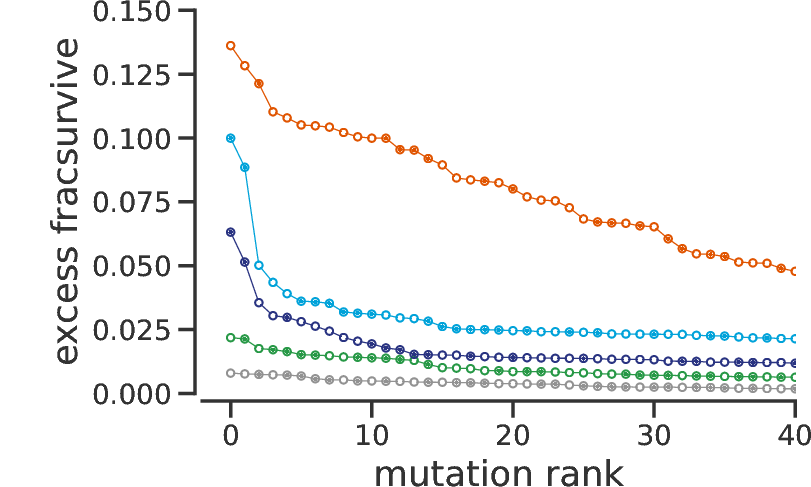

In [54]:
tempoutdir = './results/fracsurviveaboveavg/escapability_plots/Accessible/'
if not os.path.isdir(tempoutdir):
    os.mkdir(tempoutdir)


outfile = "./results/fracsurviveaboveavg/escapability_plots/Accessible/AccOnly_BG505_top100_fracsurvive.pdf"
print("top 40, ranked phi:")                           
PlotRankedMutationsFracAccessible(phiaboveavg_sub_tuple_mut, outfile, rank_lims=(-2, 40), y_lims=(0, .15), title='', make_legend=False, figsize=(6,4), ylabel='excess fracsurvive', colorcycle=colorcycle)
showPDF([outfile], width=700)

In [55]:
import pandas as pd
from colour import Color
import os

pymoldir = './results/fracsurviveaboveavg/pymol/'
if not os.path.isdir(pymoldir):
    os.mkdir(pymoldir)

def MapFracSurvtoPDB(infile, 
                     scriptfile, 
                     colors = ['#fafafa', '#ff0000'], 
                     map_type = 'site_fracsurv', 
                     restrict_to_chain = False, 
                     script_preamble = None,
                     script_postamble = None,
                     abname = None):
    '''Writes a colormapping script to be run in pymol; the colormapping is based on fracsurvive 
    to color a structure'''
    df = pd.read_csv(infile)
    df = df.dropna()
    column_names = list(df)
    
    # establish the color spectrum in hex and rgb.
    n_subdivisions = 500 # the color spectrum will be divided into this many discrete colors
    color1 = Color(colors[0])
    color2 = Color(colors[1])
    rgb_spectrum = [c.rgb for c in color1.range_to(color2, n_subdivisions)]
    rgb_spectrum_dict = dict([(i, rgb_spectrum[i]) for i in range(len(rgb_spectrum))])
    
    if map_type == 'site_fracsurv':
        assert 'avgfracsurvive' in column_names
        min_avg = df.min()['avgfracsurvive']  
        max_avg = df.max()['avgfracsurvive']  # the min and max will be mapped to color1 and color2, respectively
        range_avg = max_avg - min_avg
        df['colorindex'] =  (df.avgfracsurvive - min_avg)/range_avg*(n_subdivisions-1)
        
    elif map_type == 'max_fracsurv':
        assert 'maxfracsurvive' in column_names
        min_val = df.min()['maxfracsurvive']  
        max_val = df.max()['maxfracsurvive']  # the min and max will be mapped to color1 and color2, respectively
        range_val = max_val - min_val
        df['colorindex'] =  (df.maxfracsurvive - min_val)/range_val*(n_subdivisions-1)
    
    df['colorindex'] = df['colorindex'].astype(int) # round to nearest index
    df['rgb'] = df['colorindex'].map(rgb_spectrum_dict)        
    site_color_mapping = pd.concat([df['site'], df['rgb']], axis=1)
    
    # write out the script to *scriptfile*:
    f = open(scriptfile, 'w')
    
    if script_preamble:
        preamblef = open(script_preamble, 'r')
        for line in preamblef.readlines():
            f.write(line)
        f.write('\n\n')
        preamblef.close()
    
    for i in range(len(df.index)):
        rgblist = [min(1, c) for c in site_color_mapping.iloc[i]['rgb']]
        r = site_color_mapping.iloc[i]['site']
        
        f.write("cmd.set_color(\'color{0}\', \'{1}\')\n".format(r, rgblist))
        f.write("cmd.color(\'color{0}\', \'resi {0}\')\n".format(r))
    if script_postamble:
        postamblef = open(script_postamble, 'r')
        f.write('abname = "{0}"'.format(abname))
        for line in postamblef.readlines():
            f.write(line)
        f.write('\n\n')
        postamblef.close()
    f.close()

In [56]:
for ab in groups:
    print (ab)
    MapFracSurvtoPDB("./results/fracsurviveaboveavg/summary_{0}-mediansitefracsurvive.csv".format(ab), 
                 '{0}/{1}-sitefracsurvive_avgsitefracsurvive.py'.format(pymoldir, ab), 
                 map_type = 'site_fracsurv',
                 abname = ab)
    MapFracSurvtoPDB("./results/fracsurviveaboveavg/summary_{0}-mediansitefracsurvive.csv".format(ab), 
                 '{0}/{1}-sitefracsurvive_maxsitefracsurvive.py'.format(pymoldir, ab), 
                 map_type = 'max_fracsurv',
                 abname = ab)

118
3BNC117
VRC01
